# <font color="blue">1. Import Libraries</font>

* Install the required libraries and import.

In [1]:
#pip install imblearn

In [2]:
#pip install xgboost

In [3]:
#pip install lightgbm

In [4]:
#pip install -U scikit-learn

In [36]:
import re
import os
import math
import pickle
import sklearn
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import date
from tqdm.notebook import tqdm
from scipy.sparse import hstack, vstack
from scipy.stats import randint as sp_randint, uniform as sp_uniform
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, confusion_matrix, f1_score, roc_curve, auc, balanced_accuracy_score, matthews_corrcoef
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [37]:
pd.options.display.max_columns = None # To display all the columns of a Dataframe.
warnings.filterwarnings('ignore') # Ignore any warnings and do not show them in the cell output.

----

# <font color="blue">2. Split the Dataset into Train and Test</font>

In [7]:
# Import the final dataset generated after all the Data Preprocessing.
data = pd.read_csv('Data/finalData.csv')

In [8]:
# Split the Dataset into set of features and Class Label
dataY = data['PotentialFraud'] # Class Label
dataX = data.drop(columns='PotentialFraud') # Features

In [9]:
# Split the dataset into Train and Test in the ratio of 80:20
xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size=0.2, stratify=dataY)

In [10]:
print('Shape of the Train Dataset (Features): ', xTrain.shape)
print('Shape of the Train Dataset (Class Label)', yTrain.shape)
print('Shape of the Test Dataset (Features): ', xTest.shape)
print('Shape of the Test Dataset (Class Label)', yTest.shape)

Shape of the Train Dataset (Features):  (446568, 48)
Shape of the Train Dataset (Class Label) (446568,)
Shape of the Test Dataset (Features):  (111643, 48)
Shape of the Test Dataset (Class Label) (111643,)


----

# <font color="blue">3. Sampling - Oversampling and Undersampling</font>

* Here, we will see different sampling techniques to be used for sampling the data before training the Models.
* We would do 4 kinds of data sampling:<br>
&emsp; 1. Raw Data: Use raw data without any undersampling or oversampling.<br>
&emsp; 2. Balanced Class Weights: Use balanced class weights when using any of the Models from sklearn.<br>
&emsp; 3. Random Undersampling: Randomly undersample the majority class data to have equal number of datapoints as that in the minority class data.<br>
&emsp; 4. Oversampling using SMOTE: Oversample the minority class data to have equal number of datapoints as that in the majority class data, using SMOTE (Synthetic Minority Over-sampling Technique).<br>

## <font color="blue">3.1. Random Undersampling</font>

In [11]:
%%time
# Create an object of 'RandomUnderSampler'
rndmUndrSampler = RandomUnderSampler(sampling_strategy=1)

# Create Random Undersampled Dataset by calling the 'fit_resample' method
xTrainRndmUS, yTrainRndmUS = rndmUndrSampler.fit_resample(xTrain, yTrain)

CPU times: user 502 ms, sys: 35.5 ms, total: 538 ms
Wall time: 536 ms


In [12]:
print('Shape of the Train Dataset (Features) after Random Undersampling: ', xTrainRndmUS.shape)
print('Shape of the Train Dataset (Class Label) Random Undersampling', yTrainRndmUS.shape)

Shape of the Train Dataset (Features) after Random Undersampling:  (340472, 48)
Shape of the Train Dataset (Class Label) Random Undersampling (340472,)


In [13]:
print('After Random Undersampling, count of unique labels:')
yTrainRndmUS.value_counts()

After Random Undersampling, count of unique labels:


0    170236
1    170236
Name: PotentialFraud, dtype: int64

## <font color="blue">3.2. Over Sampling - SMOTE</font>

In [14]:
%%time
if os.path.isfile('Data/xTrainSMOTE.csv') and os.path.isfile('Data/yTrainSMOTE.csv'):

    xTrainSMOTE = pd.read_csv('Data/xTrainSMOTE.csv')
    yTrainSMOTE = pd.read_csv('Data/yTrainSMOTE.csv')

else:

    # Create an SMOTE object
    smote = SMOTE(sampling_strategy=1)
    
    # Create Oversampled Dataset by calling the 'fit_resample' method
    xTrainSMOTE, yTrainSMOTE = smote.fit_resample(xTrain, yTrain)

    ## Save the Dataset
    xTrainSMOTE.to_csv('Data/xTrainSMOTE.csv', index=False)
    yTrainSMOTE.to_csv('Data/yTrainSMOTE.csv', index=False)

CPU times: user 1.11 s, sys: 231 ms, total: 1.34 s
Wall time: 1.34 s


In [15]:
print('Shape of the Train Dataset (Features) after SMOTE Oversampling: ', xTrainSMOTE.shape)
print('Shape of the Train Dataset (Class Label) SMOTE Oversampling', yTrainSMOTE.shape)

Shape of the Train Dataset (Features) after SMOTE Oversampling:  (552664, 48)
Shape of the Train Dataset (Class Label) SMOTE Oversampling (552664, 1)


In [16]:
yTrainSMOTE = yTrainSMOTE.squeeze(axis=1) # Convert the DataFrame to Series for Class Label

In [17]:
print('After SMOTE Oversampling, count of unique labels:')
yTrainSMOTE.value_counts()

After SMOTE Oversampling, count of unique labels:


0    276332
1    276332
Name: PotentialFraud, dtype: int64

----

# <font color="blue">4. Handling Data Leakage</font>

* So far whatever features have been generated, do not have any data leakage problem.
* No data imputation has been done based on the mean, standard deviation, median, etc.
* Standardization or Normalization of the data have also not been done so far.
* Unlike the imputation techniques like mean imputation that considers all the datapoints in the dataset, the new features that have been generated like the physician, diagnosis codes, procedure codes and other code related features, have got values by considering the corresponding datapoint and not all the datapoints. Hence, this does not lead to any data leakage issue.


* However, for generating new features for the 'State' and 'Country' features like response encoding and one-hot encoding, we need to consider only training dataset and not whole dataset. Otherwise, there will be data leakage issue.
* We need to ensure that we do response encoding, one-hot encoding or standardization of the data by only considering the train dataset and not the test dataset while training a model. Otherwise, the Model would have access to the data which it would not have in real-time predictions and it would cause the model to outperform while training and under-perform in the real time.


* We will make use of **pipelines** to overcome the data leakage issues.

----

# <font color="blue">5. Encoding Categorical Features</font>

* All the features in the preprocessed dataset except 'State' and 'Country' are numerical features and can be standarized or normalized before training a model.
* State and Country features contains number encoded values (categories).
* We would do two kinds of encoding for the 'State' and 'Country' features:<br>
&emsp; 1. Response Encoding: can be used in models suitable for less dimensions like Decision Tree, Random Forest, GBDT, etc.<br>
&emsp; 2. One-hot Encoding: can be used in models like Naive Bayes, Logistic Regression, etc.<br>

## <font color="blue">5.1. Encoding Categorical Features: Response Encoding</font>

* We would use Response Encoding for the 'State' and 'Country' features.
* For each categorical feature, Response Encoding creates 'n' number of new features for an n-class classification problem.
* As this problem is a case of binary classification to identify a claim record as either fraud or non-fraud, there would be a total of 4 new features created for 'State' and 'Country' features (two for each feature).
* The value in the new feature signifies the **likelihood probability** of the feature given a particular class label.
* The below image explains the concept of Response Encoding:

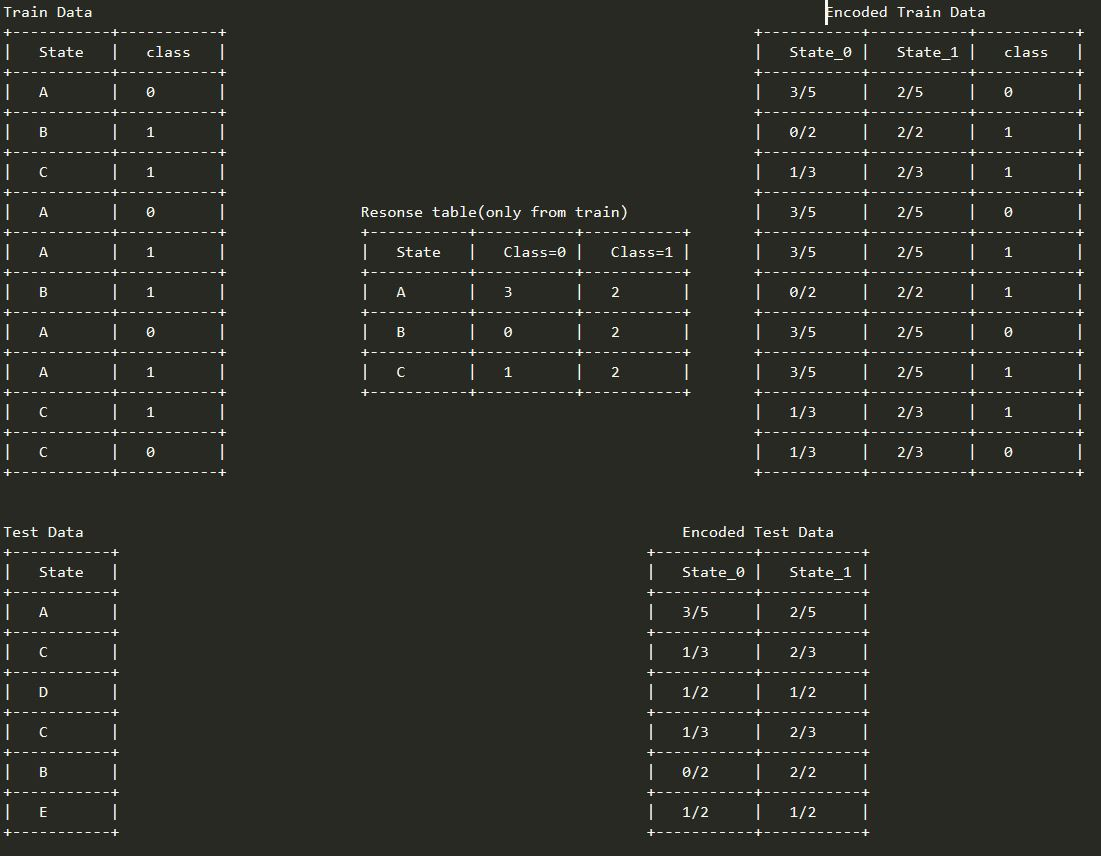

Fig. [Image Source](https://imgur.com/TufZptV)

* When we fit response encoding technique on Train dataset, it generates a Response table and encoded features.
* The test data is transformed based on the response table and new encoded features are generated for the test dataset.
* The response tabel is built only on train dataset. For a category which is not there in train data and present in test data, we will encode them with default values Ex: in our test data if have State: D then we encode it as [0.5, 0.05].

In [14]:
class ResponseEncoder(BaseEstimator, TransformerMixin):
    '''
    Class to do Response Encoding for the Categorical features.
    This class can be used in the sklearn's Pipeline to avoid data leakdage issues
    '''
    def __init__(self, categoricalFeatures, className):
        '''
        Function to initialize the class members
        
        Parameter(s):
        ------------
        categoricalFeatures: list
            List of features for which the response encoding has to be done to generate new features.
        className: str
            Name of the Class
        '''
        self.categoricalFeatures = categoricalFeatures # Categorical Features for which Response Encoding has to be done.
        self.responseTable = dict() # Dictionary to store the key:value pair with the 'key' being the categorical feature 
        # name and its 'value' as the dataFrame containing the Response Table.
        self.className = className
        self.classCount = 0 # Number of unique class labels. For binary classification, it will be 2.
        
    def fit(self, X, y):
        '''
        Function called on a Dataset (usually Train Dataset) and Class Label to generate Response Encoded Table.
        This function is called only for the train dataset and not for any cv/test dataset to avoid data leakage.
        
        Parameters:
        ----------
        X: pandas.core.frame.DataFrame
            DataFrame on which the Response Encoding has to be carried out.
        y: pandas.core.series.Series
            Class Labels of the DataFrame
        '''
        
        # Prepare a DataFrame based on the given the dataset and class label, containing just the input features and class labels
        data = pd.DataFrame()
        
        # Add the features to the dataframe
        for col in self.categoricalFeatures:
            data[col] = X[col]

        # Add the Class Label to the dataframe 
        data['PotentialFraud'] = y
        
        # Store the count of total unique class labels in the class variable 'classCount'
        self.classCount = len(y.unique())
        
        # Iterate through each of the categorical features for which Response Encoding has to be done
        for feature in self.categoricalFeatures:
            
            # Dictionary to store the unique categorical feature names and encoded feature name as keys and their values as
            # list of their corresponding values, class counts and count probabilities
            dictResponseTable = dict()
            
            uniqueFeatValues = np.sort(X[feature].unique()) # Array of unique feature values
            uniqueClassLabels = np.sort(y.unique()) # Array of unique class labels
            
            # Iterate through each of the categorical feature values and generate the Response Table
            for featureVal in uniqueFeatValues:
                
                countClass = list() # List to store the count/frequency of a Class label for a particular feature.
                probClass = list() # List to store the probability of occurence of a class label for a particular feature.
                
                # Loop through the unique Class Labels and find the count of the feature value
                for label in uniqueClassLabels:
                    
                    # Append the frequency of Class Label 'label' for the feature 'featureVal' to the list 'countClass'
                    countClass.append(data[(data[feature] == featureVal) & (data[self.className] == label)][self.className].count())
                    
                
                # Loop through the unique Class Labels and find the likelihood probability of the feature value
                for label in uniqueClassLabels:
                    
                    # Append the likelihood probability of the occurence of the class 'label' for the feature 'featureVal'
                    probClass.append(countClass[label]/sum(countClass))
                    
                
                # Prepare a dictionary having keys as features (original and new features) and their values as 
                # feature value (for original features), class counts and class probabilities
                
                # Check if the key already exist or not in the dictionary. If not, create it
                if (feature not in dictResponseTable.keys()):
                    dictResponseTable[feature] = []
                dictResponseTable[feature].append(featureVal) # Append the current iteration's feature value 'feature'
                
                # For each unique class label, add the class label and probability to the corresponding keys in the dictionary
                for label in uniqueClassLabels:
                    
                    if (feature + 'Class' + str(label) not in dictResponseTable.keys()):
                        dictResponseTable[feature + 'Class' + str(label)] = []
                    if (feature + '_' + str(label) not in dictResponseTable.keys()):
                        dictResponseTable[feature + '_' + str(label)] = []
                    dictResponseTable[feature + 'Class' + str(label)].append(countClass[label])
                    dictResponseTable[feature + '_' + str(label)].append(probClass[label])
                    
            # Prepare and store the Response Table in the dictionary 'self.responseTable'
            self.responseTable[feature] = pd.DataFrame(dictResponseTable)
        
        return self
    
    def transform(self, X, y= None):
        '''
        Function called on a Dataset (Train/Test Dataset) and/or Class Label to generate Response Encoded Features.
        This is called to avoid any data leakage. This uses the Response Table already prepared by the fit() method
        and does not consider the test dataset.
        
        Parameters:
        ----------
        X: pandas.core.frame.DataFrame
            DataFrame on which the Response Encoding has to be done.
        y: pandas.core.series.Series
            Class Labels of the DataFrame
        '''
        
        # Get a copy of the input dataframe such the input dataframe is not modified.
        xEncoded = X.copy()
        
        listResponseEncFeat = list() # List to store the names of the response encoded features.
        
        # Iterate through each of the categorical features for which Response Encoding has to be done
        for feature in self.categoricalFeatures:
        
            # Merge with the Response Table Dataframe
            xEncoded = pd.merge(left=xEncoded, right=self.responseTable[feature], how='left', on=feature)
            
            # Form the list of the features (original and class count) to be dropped from the Dataset
            listResponseEncFeat.extend([col for col in list(self.responseTable[feature].columns) if '_' not in col])
            
        # Fill the values for the datapoints which are not present in the Response Table with equal probabilities of the class
        xEncoded.fillna(1/self.classCount)
        
        # Drop the original features and class count features. Keep only the response encoded features having class prob.
        xEncoded.drop(columns=listResponseEncFeat, inplace=True)
        
        # Convert the values of the dataframe to numeric.
        xEncoded.apply(pd.to_numeric)
        
        # Fill the empty/missing values with 0.
        xEncoded.fillna(0, inplace=True)
        
        # Return this DataFrame with all the numerical features and the response encoded features for the categorical features
        return xEncoded

### <font color="blue">5.1.1. Use of custom ResponseEncoder Class</font>

* We will see how to use ResponseEncoder class for generating response encoded features without causing data leakage.

In [15]:
%%time
# Create an object of the 'ResponseEncoder' class
responseEnc = ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')

# Fit the 'ResponseEncoder' class object on only Train Data
responseEnc.fit(xTrain, yTrain)

CPU times: user 1.04 s, sys: 11.7 ms, total: 1.05 s
Wall time: 1.05 s


ResponseEncoder(categoricalFeatures=['State', 'Country'],
                className='PotentialFraud')

In [16]:
%%time
# Transform the 'ResponseEncoder' class object to get the response encoded features for the categorical features:
# 'State' and 'Country'
xTrainRE = responseEnc.transform(xTrain) # Train Data

xTestRE = responseEnc.transform(xTest) # Test Data

CPU times: user 494 ms, sys: 304 ms, total: 798 ms
Wall time: 797 ms


In [17]:
print('Shape of the Train Data before doing response encoding of \'State\' and \'Country\' Features:',  xTrain.shape)
print('Shape of the Test Data before doing response encoding of \'State\' and \'Country\' Features:',  xTest.shape)
print('Shape of the Train Data after doing response encoding of \'State\' and \'Country\' Features:',  xTrainRE.shape)
print('Shape of the Test Data after doing response encoding of \'State\' and \'Country\' Features:',  xTestRE.shape)

Shape of the Train Data before doing response encoding of 'State' and 'Country' Features: (446568, 48)
Shape of the Test Data before doing response encoding of 'State' and 'Country' Features: (111643, 48)
Shape of the Train Data after doing response encoding of 'State' and 'Country' Features: (446568, 50)
Shape of the Test Data after doing response encoding of 'State' and 'Country' Features: (111643, 50)


* We can see that 2 extra features are available after doing response encoding and not 4. This is because the original State and Country features were removed and 4 new features were added. Hence, the total change is 4 - 2 = 2.

In [18]:
# Display top 5 records from the response encoded Train Dataset
xTrainRE.head()

,ClmAdmitDiagnosisCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_2,Gender,Race,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimSettlementDelay,TreatmentDuration,Age,IsDead,TotalClaimAmount,IPTotalAmount,OPTotalAmount,UniquePhysCount,PhysRoleCount,IsSamePhysMultiRole1,IsSamePhysMultiRole2,PHY412132,PHY337425,PHY330576,ClmDiagCode_4019,ClmDiagCode_2724,ClmDiagCode_42731,ClmDiagCode_25000,ClmDiagCode_2449,ClmDiagCode_53081,ClmDiagCode_4280,ClmProcCode_9904.0,ClmProcCode_8154.0,ClmProcCode_66.0,ClmProcCode_3893.0,ClmProcCode_3995.0,State_0,State_1,Country_0,Country_1
0,0,1,1,0,0,0,0,2,1,0,1,1,0,0,1,1,1,0,0,0,0,0,57,0,3300,0,19430,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.590346,0.409654,0.630892,0.369108
1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,73,0,1800,0,2210,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.601403,0.398597,0.575073,0.424927
2,1,1,0,0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,80,0,300,0,600,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.836337,0.163663,0.704473,0.295527
3,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,0,71,0,1400,0,1750,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.601403,0.398597,0.770015,0.229985
4,0,1,1,0,0,0,0,1,0,1,1,1,0,1,0,1,0,1,0,0,0,0,78,0,30,0,4180,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.500785,0.499215,0.636886,0.363114


In [19]:
# Display top 5 records of the response encoded features
xTrainRE[[col for col in xTrainRE.columns if re.match(r'(State|Country)[_]*[0-9]*', col)]].head()

,State_0,State_1,Country_0,Country_1
0,0.590346,0.409654,0.630892,0.369108
1,0.601403,0.398597,0.575073,0.424927
2,0.836337,0.163663,0.704473,0.295527
3,0.601403,0.398597,0.770015,0.229985
4,0.500785,0.499215,0.636886,0.363114


In [20]:
# Display top 5 records from the response encoded Test Dataset
xTestRE.head()

,ClmAdmitDiagnosisCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_2,Gender,Race,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimSettlementDelay,TreatmentDuration,Age,IsDead,TotalClaimAmount,IPTotalAmount,OPTotalAmount,UniquePhysCount,PhysRoleCount,IsSamePhysMultiRole1,IsSamePhysMultiRole2,PHY412132,PHY337425,PHY330576,ClmDiagCode_4019,ClmDiagCode_2724,ClmDiagCode_42731,ClmDiagCode_25000,ClmDiagCode_2449,ClmDiagCode_53081,ClmDiagCode_4280,ClmProcCode_9904.0,ClmProcCode_8154.0,ClmProcCode_66.0,ClmProcCode_3893.0,ClmProcCode_3995.0,State_0,State_1,Country_0,Country_1
0,0,1,0,0,0,0,1,1,0,1,1,1,0,0,1,1,1,0,1,1,0,0,87,0,60,7068,3410,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.526667,0.473333,0.428235,0.571765
1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,80,1,40,0,4860,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.651818,0.348182,0.736295,0.263705
2,0,1,1,0,0,0,1,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,67,0,140,13268,450,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.763382,0.236618,0.738792,0.261208
3,1,1,1,0,0,0,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,66,0,60,3068,3860,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.407328,0.592672,0.715095,0.284905
4,1,1,1,0,0,0,0,2,0,0,0,0,0,0,0,1,1,0,0,0,0,0,52,0,100,0,4060,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.763382,0.236618,0.668994,0.331006


In [21]:
# Display top 5 records of the response encoded features
xTestRE[[col for col in xTestRE.columns if re.match(r'(State|Country)[_]*[0-9]*', col)]].head()

,State_0,State_1,Country_0,Country_1
0,0.526667,0.473333,0.428235,0.571765
1,0.651818,0.348182,0.736295,0.263705
2,0.763382,0.236618,0.738792,0.261208
3,0.407328,0.592672,0.715095,0.284905
4,0.763382,0.236618,0.668994,0.331006


## <font color="blue">5.2. Encoding Categorical Features: One-hot Encoding</font>

* We would do one-hot encoding of the categorical features viz., 'State' and 'Country'.
* In order to avoid any data leakage issue, we will make use of sklearn's Pipeline.
* Inorder to use the Pipeline, we need to create a class with fit() and transform() method inheriting BaseEstimator, TransformerMixin class.

In [22]:
class OneHotEncoder(BaseEstimator, TransformerMixin):
    '''
    Class to do One-hot Encoding for the Categorical features.
    This class can be used in the sklearn's Pipeline to avoid data leakdage issues
    '''
    def __init__(self, categoricalFeatures):
        '''
        Function to initialize the class members
        
        Parameter(s):
        ------------
        categoricalFeatures: list
            List of features for which the response encoding has to be done to generate new one-hot encoded features.
        '''
        self.categoricalFeatures = categoricalFeatures # Categorical Features for which One-hot Encoding has to be done.
        self.countVectorizers = dict() # Dictionary of CountVectorizer object for each features to be one-hot encoded.
        
        # Add CountVectorizer object for each feature to the dictionary 'self.countVectorizers'
        for feature in categoricalFeatures:
            
            # 'CountVectorizer not considering single letter text': https://stackoverflow.com/a/63339533/16007029
            self.countVectorizers[feature] = CountVectorizer(tokenizer=lambda x: x.split())
        
    def fit(self, X, y=None):        
        '''
        Function called on a Dataset (usually Train Dataset) to generate One-hot Encoded Features.
        This function is called only for the train dataset and not for any cv/test dataset to avoid data leakage.
        
        Parameters:
        ----------
        X: pandas.core.frame.DataFrame
            DataFrame on which the Response Encoding has to be carried out.
        '''
        
        # Fit the CountVectorizer object for each feature, on the Train Data feature
        for feature in self.categoricalFeatures:
            
            self.countVectorizers[feature].fit(pd.Series(X[feature]).astype(str).values)
            
        return self
    
    def transform(self, X, y=None):
        '''
        Function called on a Dataset (Train/Test Dataset) and/or Class Label to generate One-hot Encoded Features.
        This is called to avoid any data leakage. This uses the CountVectorizer object already prepared by the fit() method
        and does not consider the test dataset.
        
        Parameters:
        ----------
        X: pandas.core.frame.DataFrame
            DataFrame on which the One-hot Encoding has to be done.
        '''
        
        # Create a copy of the dataframe so that it does not modify the input dataframe
        xEncoded = X.copy()
        
        oneHotEncodedFeatures = dict() # Dictionary to store the feature name as key and its one-hot encoded csr matrix in its value
        
        # Transform each of the categorical feature to convert to one-hot encoding
        for feature in self.categoricalFeatures:
            
            oneHotEncodedFeatures[feature] = self.countVectorizers[feature].transform(pd.Series(xEncoded[feature]).astype(str).values)
            
        # Remove the original categorical features from the Dataset
        xEncoded.drop(columns=self.categoricalFeatures, inplace=True)
        
        # Stack (horizontally) the new one-hot encoded features to the dataset
        for feature in self.categoricalFeatures:
            
            xEncoded = hstack((xEncoded, oneHotEncodedFeatures[feature])).tocsr()
            
        # Return this DataFrame with all the numerical features and the one-hot encoded features for the categorical features
        return xEncoded

### <font color="blue">5.2.1. Use of custom OneHotEncoder Class</font>

* We will see how to use OneHotEncoder class for generating one-hot encoded features without causing data leakage.

In [23]:
%%time
# Create an object of the 'OneHotEncoder' class
onehotEnc = OneHotEncoder(categoricalFeatures=['State', 'Country'])

# Fit the 'OneHotEncoder' class object on only Train Data
onehotEnc.fit(xTrain, yTrain)

CPU times: user 2.65 s, sys: 60.1 ms, total: 2.71 s
Wall time: 2.71 s


OneHotEncoder(categoricalFeatures=['State', 'Country'])

In [24]:
%%time
# Transform the 'OneHotEncoder' class object to get the one-hot encoded features for the categorical features:
# 'State' and 'Country'
xTrainOHE = onehotEnc.transform(xTrain) # Train Data

xTestOHE = onehotEnc.transform(xTest) # Test Data

CPU times: user 4.27 s, sys: 275 ms, total: 4.54 s
Wall time: 4.54 s


In [25]:
print('Shape of the Train Data before doing one-hot encoding of \'State\' and \'Country\' Features:',  xTrain.shape)
print('Shape of the Test Data before doing one-hot encoding of \'State\' and \'Country\' Features:',  xTest.shape)
print('Shape of the Train Data after doing one-hot encoding of \'State\' and \'Country\' Features:',  xTrainOHE.shape)
print('Shape of the Test Data after doing one-hot encoding of \'State\' and \'Country\' Features:',  xTestOHE.shape)

Shape of the Train Data before doing one-hot encoding of 'State' and 'Country' Features: (446568, 48)
Shape of the Test Data before doing one-hot encoding of 'State' and 'Country' Features: (111643, 48)
Shape of the Train Data after doing one-hot encoding of 'State' and 'Country' Features: (446568, 409)
Shape of the Test Data after doing one-hot encoding of 'State' and 'Country' Features: (111643, 409)


In [26]:
print('Number of unique states in the Train Dataset: ', len(xTrain['State'].unique()))
print('Number of unique countried in the Train Dataset: ', len(xTrain['Country'].unique()))

Number of unique states in the Train Dataset:  52
Number of unique countried in the Train Dataset:  311


* We can see that 52 + 314 = 366 extra features were added after doing one-hot encoding and original 2 features were removed.
* Hence the total count matched:<br>
&emsp; * Total Original Features (48) - Removal of categorical Features 'State' and 'Country' (2) + one-hot encoded features for 'State' (52) + one-hot encoded features for 'Country' (314) = 412.<br>
&emsp; * 48 - 2 + 52 + 314 = 412

In [27]:
print('Final Dataset 1 (with Response Encoded State and Country Features):')
print('--'*40)
print('Train Dataset: Features-', xTrainRE.shape, ', Class Labels: ', yTrain.shape)
print('Test Dataset: Features-', xTestRE.shape, ', Class Labels: ', yTest.shape)

print('=='*40)

print('Final Dataset 2 (with One-hot Encoded State and Country Features):')
print('--'*40)
print('Train Dataset: Features-', xTrainOHE.shape, ', Class Labels: ', yTrain.shape)
print('Test Dataset: Features-', xTestOHE.shape, ', Class Labels: ', yTest.shape)

Final Dataset 1 (with Response Encoded State and Country Features):
--------------------------------------------------------------------------------
Train Dataset: Features- (446568, 50) , Class Labels:  (446568,)
Test Dataset: Features- (111643, 50) , Class Labels:  (111643,)
Final Dataset 2 (with One-hot Encoded State and Country Features):
--------------------------------------------------------------------------------
Train Dataset: Features- (446568, 409) , Class Labels:  (446568,)
Test Dataset: Features- (111643, 409) , Class Labels:  (111643,)


## <font color="blue">5.3. Encoding Numerical Features: Column Standardization</font>

* We will standardize the below numerical features available in the dataset:<br>
&emsp; i. Race<br>
&emsp; ii. ClaimSettlementDelay<br>
&emsp; iii. TreatmentDuration<br>
&emsp; iv. Age<br>
&emsp; v. TotalClaimAmount<br>
&emsp; vi. IPTotalAmount<br>
&emsp; vii. OPTotalAmount<br>
&emsp; viii. UniquePhysCount<br>
&emsp; viii. PhysRoleCount<br>


* Again for standardizing the features, we need to ensure that there is no data leakage.
* Hence, we will create a class with fit() and transform() method inheriting BaseEstimator, TransformerMixin class.

In [28]:
class Standardize(BaseEstimator, TransformerMixin):
    '''
    Class to do standardization of the numerical features.
    This class can be used in the sklearn's Pipeline to avoid data leakdage issues
    '''
    def __init__(self, numericalFeatures):
        '''
        Function to initialize the class members
        
        Parameter(s):
        ------------
        numericalFeatures: list
            List of numerical features to be standardized.
        '''
        self.numericalFeatures = numericalFeatures # Numerical Features to be standardized.
        self.standardScaler = StandardScaler() # Object of StandardScaler.
        
    def fit(self, X, y=None):        
        '''
        Function called on a Dataset (usually Train Dataset) to fit the train dataset.
        This function is called only for the train dataset and not for any cv/test dataset to avoid data leakage.
        
        Parameters:
        ----------
        X: pandas.core.frame.DataFrame
            Dataset to be considered for standardization.
        '''
        
        # Fit the StandardScaler object only on the numerical features.
        self.standardScaler.fit(X[self.numericalFeatures])        
            
        return self
    
    def transform(self, X, y=None):
        '''
        Function called on a Dataset (Train/Test Dataset) to standardize the data based on the Train Dataset.
        This is called to avoid any data leakage. This uses the standardScaler object already prepared by the fit() method
        and does not consider the test dataset.
        
        Parameters:
        ----------
        X: pandas.core.frame.DataFrame
            Dataset to be standardized.
        '''
        
        # Create a copy of the dataframe so that it does not modify the input dataframe
        xStandardized = X.copy()
        
        # Standardize the numerical features of the dataset.
        xStandardized[self.numericalFeatures] = self.standardScaler.transform(xStandardized[self.numericalFeatures])
            
        # Return the standardized dataset
        return xStandardized

### <font color="blue">5.3.1. Use of custom Standardize Class</font>

* We will see how to use Standardize class for generating standardizing numerical features without causing data leakage.

In [29]:
%%time

# Create a list of numerical features to be standardized.
featuresToStd = ['Race', 'ClaimSettlementDelay', 'TreatmentDuration', 'Age', 'TotalClaimAmount',
                 'IPTotalAmount', 'OPTotalAmount', 'UniquePhysCount', 'PhysRoleCount']

# Create an object of the 'Standardize' class
std = Standardize(numericalFeatures=featuresToStd)

# Fit the 'Standardize' class object on only Train Data
std.fit(xTrain, yTrain)

CPU times: user 45.7 ms, sys: 7.54 ms, total: 53.3 ms
Wall time: 52.4 ms


Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                               'TreatmentDuration', 'Age', 'TotalClaimAmount',
                               'IPTotalAmount', 'OPTotalAmount',
                               'UniquePhysCount', 'PhysRoleCount'])

In [30]:
%%time
# Transform the 'Standardize' class object to standardize the numerical features
xTrainStd = std.transform(xTrain) # Train Data

xTestStd = std.transform(xTest) # Test Data

CPU times: user 309 ms, sys: 316 ms, total: 626 ms
Wall time: 624 ms


In [31]:
# Display the top 5 records in the standardized train dataset
xTrainStd.head()

,ClmAdmitDiagnosisCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_2,Gender,Race,RenalDiseaseIndicator,State,Country,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimSettlementDelay,TreatmentDuration,Age,IsDead,TotalClaimAmount,IPTotalAmount,OPTotalAmount,UniquePhysCount,PhysRoleCount,IsSamePhysMultiRole1,IsSamePhysMultiRole2,PHY412132,PHY337425,PHY330576,ClmDiagCode_4019,ClmDiagCode_2724,ClmDiagCode_42731,ClmDiagCode_25000,ClmDiagCode_2449,ClmDiagCode_53081,ClmDiagCode_4280,ClmProcCode_9904.0,ClmProcCode_8154.0,ClmProcCode_66.0,ClmProcCode_3893.0,ClmProcCode_3995.0
429895,0,1,1,0,0,0,0,1.038287,1,26,90,0,1,1,0,0,1,1,1,0,0,0,-0.352449,-0.194362,-1.292044,0,0.554888,-0.46027,3.453990,-0.579836,0.688231,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
267963,0,1,1,0,0,0,0,-0.355614,0,23,810,0,0,0,0,0,0,0,1,0,0,0,-0.352449,-0.194362,-0.063550,0,0.180651,-0.46027,-0.151239,1.401056,0.688231,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
278203,1,1,0,0,0,0,1,-0.355614,0,18,40,0,1,0,0,1,1,0,1,0,0,0,-0.352449,-0.194362,0.473916,0,-0.193585,-0.46027,-0.488313,-0.579836,-0.875095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
171079,0,1,1,0,0,0,0,-0.355614,0,23,540,0,0,0,0,0,0,0,0,0,0,0,0.666039,-0.194362,-0.217112,0,0.080855,-0.46027,-0.247546,1.401056,0.688231,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
266416,0,1,1,0,0,0,0,-0.355614,0,33,420,1,1,1,0,1,0,1,0,1,0,0,-0.352449,-0.194362,0.320354,0,-0.260948,-0.46027,0.261206,3.381948,2.251558,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [32]:
# Display the top 5 records in the standardized test dataset
xTestStd.head()

,ClmAdmitDiagnosisCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_2,Gender,Race,RenalDiseaseIndicator,State,Country,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimSettlementDelay,TreatmentDuration,Age,IsDead,TotalClaimAmount,IPTotalAmount,OPTotalAmount,UniquePhysCount,PhysRoleCount,IsSamePhysMultiRole1,IsSamePhysMultiRole2,PHY412132,PHY337425,PHY330576,ClmDiagCode_4019,ClmDiagCode_2724,ClmDiagCode_42731,ClmDiagCode_25000,ClmDiagCode_2449,ClmDiagCode_53081,ClmDiagCode_4280,ClmProcCode_9904.0,ClmProcCode_8154.0,ClmProcCode_66.0,ClmProcCode_3893.0,ClmProcCode_3995.0
527499,0,1,0,0,0,0,1,-0.355614,0,39,470,1,1,1,0,0,1,1,1,0,1,1,-0.352449,-0.194362,1.011382,0,-0.253463,0.099660,0.099997,-0.579836,-0.875095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
149941,0,1,1,0,0,0,0,-0.355614,0,14,640,1,0,0,0,0,0,0,1,0,1,0,-0.352449,-0.194362,0.473916,1,-0.258453,-0.460270,0.403573,-0.579836,-0.875095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
409220,0,1,1,0,0,0,1,-0.355614,0,34,100,1,1,0,1,0,1,0,1,0,0,1,-0.352449,-0.194362,-0.524235,0,-0.233504,0.590826,-0.519717,-0.579836,-0.875095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
288218,1,1,1,0,0,0,1,2.432187,0,5,500,0,0,0,0,0,1,0,0,0,0,0,-0.352449,-0.194362,-0.601016,0,-0.253463,-0.217222,0.194210,-0.579836,-0.875095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105110,1,1,1,0,0,0,0,1.038287,0,34,230,0,0,0,0,0,0,1,1,0,0,0,-0.352449,-0.194362,-1.675948,0,-0.243484,-0.460270,0.236083,-0.579836,-0.875095,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


* Here, we can see that only the features 'Race', 'ClaimSettlementDelay', 'TreatmentDuration', 'Age', 'TotalClaimAmount', 'IPTotalAmount', 'OPTotalAmount', 'UniquePhysCount' and 'PhysRoleCount' have been standardized.

----

# <font color="blue">6. Performance Metrics</font>

* Here, we will define some utility functions to find the performance metrics which will be used in evaluating the models.

## <font color="blue">6.1. Performance Metric - Binary Log Loss</font>

* Log loss is an important metric when the model finds the probability estimates..
* It lies in the range [0, $\infty$)
* Given by the equation:<br>
= <font color="brown" size="5"><b>- $\frac{1}{N}$ $\{ \sum_{i=1}^{n} y_i . log(P(\hat{y}_i)) + (1 - y_i) . log(1 - P(\hat{y}_i)) \}$</b></font>
* where,<br>
&emsp; N: Total number of datapoints.<br>
&emsp; y<sub>i</sub>: Actual class label and has value either 0 or 1.<br>
&emsp; $P(\hat{y}_i)$: Predicted Probability.<br>

In [18]:
def getLogloss(yActual, yPredProb, datasetType='Test'):
    '''
    Finds and displays the Log Loss
    
    Parameters:
    ----------
    yActual: array-like
        Ground truth (correct) class labels for 'n' samples.
    yPredProb: array-like
        Predicted probabilities, as returned by a model's predict_proba method.
    datasetType: str
        Type of Dataset: Test or Train.
    '''
    
    logloss = log_loss(y_true=yActual, y_pred=yPredProb)
    
    print('Log-loss of the Model on ', datasetType ,' Dataset: ', logloss)

## <font color="blue">6.2. Performance Metric - Confusion Matrix and other related metrics</font>

* Here, we will plot Confusion Matrix and will derive different metrics from the values of a Confusion Matrix.

### <font color="blue">6.2.1. Precision Matrix</font>
* Precision Matrix helps in knowing the Precision values along the diagonal elements.
* **Precision** indicates - "Of all predicted positives, how many are actual positives".
* Given by the equation:<br>
<font color="green" size="4"><b>Precision (Positive Predictive Value (PPV)) = $\frac{TP}{TP\:+\:FP}$</b></font>
* The other diagonal element in the matrix tells - "Of all predicted negatives, how many are actual negatives".
* Given by the equation:<br>
<font color="green" size="4"><b>Negative Predictive Value (NPV) = $\frac{TN}{TN\:+\:FN}$</b></font>

### <font color="blue">6.2.2. Recall Matrix</font>
* Recall Matrix helps in knowing the Recall (or Senstivity) and Specificity values along the diagonal elements.
* **Recall/Sensitivity or TPR (True Positive Rate)** indicates - "Of all actual positives, how many are predicted positives".
* Given by the equation:<br>
<font color="green" size="4"><b>Recall/Sensitivity = $\frac{TP}{P}$</b></font>
* **Specificity** indicates - "Of all actual negatives, how many are predicted negatives".
* Given by the equation:<br>
<font color="green" size="4"><b>Specificity = $\frac{TN}{N}$</b></font>

### <font color="blue">6.2.3. FPR and FNR</font>
* **Fall-out or FPR (False Positive Rate)** indicates - "Of all actual negatives, how many are predicted positives".
* Given by the equation:<br>
<font color="green" size="4"><b>FPR = $\frac{FP}{N}$</b></font>
* **Miss rate or FNR (False Negative Rate)** indicates - "Of all actual positives, how many are predicted negatives".
* Given by the equation:<br>
<font color="green" size="4"><b>FNR = $\frac{FN}{P}$</b></font>

### <font color="blue">6.2.4. Balanced Accuracy Score (BACC)</font>
* Focuses on high recall (TPR and TNR). Computes balanced accuracy and is the average of recall obtained on each class.
* Given by the equation:<br>
<font color="green" size="4"><b>BACC Score = $\frac{Recall\:of\:+ve\:class \;+\; Recall\:of\:-ve\:class}{2}$</b></font>

### <font color="blue">6.2.5. Matthew's Correlation Coefficient (MCC)</font>:
* Considers all the values from a confusion matrix and gives more value when the predictions are correct.
* Given by the equation:<br>
<font color="green" size="4"><b>MCC Score = $\frac{TP\:.\:TN \;-\; FP\:.\:FN}{\sqrt{(TP\:+\:FP)(TP\:+\:FN)(TN\:+\:FP)(TN\:+\:FN)}}$</b></font>

In [19]:
def plotPerformanceMatrix(yActual, yPred):
    '''
    Function to compute Confusion, Precision and Recall Matrix and plot them.
    
    Parameters:
    ----------
    yActual: array-like
        Ground truth (correct) class labels for 'n' samples.
    yPred: array-like
        Predicted class labels for 'n' samples.
    '''
    
    # Get Confusion Matrix based on the input 'yActual' and 'yPred'.
    confusionMatrix = confusion_matrix(y_true=yActual, y_pred=yPred)
    
    # Compute the Precision Matrix
    precisionMatrix = (confusionMatrix/confusionMatrix.sum(axis=0))
    # Divide each element of the confusion matrix with the sum of the elements in that column (total predicted value)
    
    # Compute the Recall Matrix
    recallMatrix = (confusionMatrix.T/confusionMatrix.sum(axis=1)).T
    # Divide each element of the confusion matrix with the sum of the elements in that row (total actual values)
    
    plt.figure(figsize=(20,5))
    
    # Plot the Confusion Matrix.
    plt.subplot(131)
    sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Reds')
    plt.title('Confusion Matrix on Test Data', fontsize=20)
    plt.xlabel('Predicted Value', fontsize=15) # Label on the x-axis
    plt.ylabel('Actual Values', fontsize=15) # Label on the y-axis
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted: NO (Non-fraud)', 'Predicted: YES (Fraud)'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Actual: NO (Non-fraud)', 'Actual: YES (Fraud)'], rotation=0)
    
    # Plot the Precision Matrix.
    plt.subplot(132)
    sns.heatmap(precisionMatrix, annot=True, fmt='.3f', cmap=sns.light_palette('green'))
    plt.title('Precision Matrix on Test Data', fontsize=20)
    plt.xlabel('Predicted Value', fontsize=15) # Label on the x-axis
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted: NO (Non-fraud)', 'Predicted: YES (Fraud)'])
    
    # Plot the Recall Matrix.
    plt.subplot(133)
    sns.heatmap(recallMatrix, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Recall Matrix on Test Data', fontsize=20)
    plt.xlabel('Predicted Value', fontsize=15) # Label on the x-axis
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted: NO (Non-fraud)', 'Predicted: YES (Fraud)'])
    plt.show()
    
    totalDatapoints = len(yActual) # Total number of Datapoints
    print('Percentage of misclassified points (Test Data): ', ((totalDatapoints - np.trace(confusionMatrix))/totalDatapoints)*100, '%')
    print('Sum of columns in the Precision Matrix: ', precisionMatrix.sum(axis=0))
    print('Sum of rows in the Recall Matrix: ', recallMatrix.sum(axis=1))
    
    # Find Total Negatives and Total Positives (Actual/ ground truth)
    totalNegative, totalPositive = tuple(confusionMatrix.sum(axis=1))
    
    # Find True Positive, False Positive, False Negative and True Positive
    tn, fp, fn, tp = confusionMatrix.ravel()
    
    # Calculate the FPR and FNR
    fpr = fp / totalNegative
    fnr = fn / totalPositive
    print('False Positive Rate (FPR) on Test Data: ', fpr)
    print('False Negative Rate (FNR) on Test Data: ', fnr)
    
    # Get the BACC Score
    bacc = balanced_accuracy_score(y_true=yActual, y_pred=yPred)
    print('Balanced Accuracy Score (BACC) on Test Data: ', bacc)
    
    # Get the MCC Score
    mcc = matthews_corrcoef(y_true=yActual, y_pred=yPred)
    print('Matthew\'s Correlation Coefficient (MCC) on Test Data: ', mcc)

## <font color="blue">6.3. Performance Metric - F1 Score</font>

* Given by the equation:<br>
<font color="green" size="5"><b>F1-Score = $\frac{2 . Precision . Recall}{Precision + Recall}$</b></font>

In [20]:
def getProbEstimates(yPredProb, positiveClass=True, batchSize=1000):
    '''
    Returns the Probability Estimates of the data as predicted by the model, for the given Class.
    Class can be negative (0) or positive (1).
    This function returns the Probability Estimates of the positive class (1) by default.
    
    Parameters:
    -----------
    yPredProb: array-like
        Contains the Predicted Probability Scores of both -ve (0) and +ve (1) class.
    positiveClass: bool
        Flag to decide whether to find the Probability Estimates for a positive class (True) or negative class (False).
    batchSize: int
        Size of the batch to precessed at a time.
    '''
    
    # Check if the input Predicted variable is a Probabilty Estimates or not
    if len(yPredProb.shape) == 1:
        print('Please pass the Probability Estimates')
        return
    
    probEstimates = list() # Variable to store the Predicted Probability Estimates
    classIndex = 1 # Index of the Class (For -ve class, it should be 0 and for +ve class, it should be 1)
    if positiveClass == False:
        classIndex = 0
    batchsize = batchSize # Process a batch of given size.
    totalCnt = yPredProb.shape[0] # Total number of Datapoints
    datapointCount = totalCnt - totalCnt%batchsize # Total no. of datapoints minus the last batch of datapoint
    
    # Loop through the dataset batch-wise
    for i in range(0, datapointCount, batchsize):
        probEstimates.extend(yPredProb[i : i + batchsize][:,classIndex]) # Add Probability Estimates of +ve class
        
    # Find the Probability Estimate for the remaining last batch
    if totalCnt%batchsize != 0:
        probEstimates.extend(yPredProb[datapointCount:][:,classIndex])
    
    return probEstimates

In [21]:
def getF1Score(yActual, yPred):
    '''
    Calculates and displays the F1-Score
    
    Parameters:
    ----------
    yActual: array-like
        Ground truth (correct) class labels for 'n' samples.
    yPred: array-like
        Predicted class labels for 'n' samples.
    '''
    
    f1Score = f1_score(y_true=yActual, y_pred=yPred)
    
    print('F1-Score of the Model on Test Data: ', f1Score)

## <font color="blue">6.3. Performance Metric - AUC</font>

* AUC is the Area under the curve of ROC (Receiver Operating Characteristic).

In [22]:
def plotROC(yTestActual, yTestPredProb, yTrainActual=None, yTrainPredProb=None):
    '''
    Plots the ROC and calculates the AUC
    
    Parameters:
    ----------
    yTestActual: array-like
        Ground truth (correct) class labels for 'n' samples on Test Dataset.
    yTestPredProb: array-like
        Predicted probabilities, as returned by a model's predict_proba method on Test Dataset.
    yTrainActual: array-like
        Ground truth (correct) class labels for 'n' samples on Train Dataset.
    yTrainPredProb: array-like
        Predicted probabilities, as returned by a model's predict_proba method on Train Dataset.
    '''
    
    # Check if the input Predicted variable is a Probabilty Estimates or not
    if len(yTestPredProb.shape) == 1:
        print('Please pass the correct Probability Estimates')
        return
    
    # Calculate the Predicted Probability Estimates for the positive class of Test Data
    yTestPredPE = getProbEstimates(yTestPredProb)
    
    # Find the FPR, TPR and Threshold values for the Test Data
    fprTest, tprTest, thresholdTest = roc_curve(yTestActual, yTestPredPE)
    
    # Find the AUC
    areaTest = auc(fprTest, tprTest)

    # If Train Dataset to also to be considered for plotting ROC
    if (type(yTrainActual) != type(None) and type(yTrainPredProb) != type(None)):

        # Check if the input Predicted variable is a Probabilty Estimates or not
        if len(yTrainPredProb.shape) == 1:
            print('Please pass the correct Probability Estimates')
            return
        
        # Calculate the Predicted Probability Estimates for the positive class of Train Data
        yTrainPredPE = getProbEstimates(yTrainPredProb)
        
        # Find the FPR, TPR and Threshold values for the Train Data
        fprTrain, tprTrain, thresholdTrain = roc_curve(yTrainActual, yTrainPredPE)
        
        # Find the AUC
        areaTrain = auc(fprTrain, tprTrain)
    
    # Plot the ROC Curve
    # If Train Dataset to also to be considered for plotting ROC
    if (type(yTrainActual) != type(None) and type(yTrainPredProb) != type(None)):

        plt.plot(fprTrain, tprTrain, label= 'Train AUC: ' + str(areaTrain))

    plt.plot(fprTest, tprTest, label= 'Test AUC: ' + str(areaTest))
    plt.legend()
    # If Train Dataset to also to be considered for plotting ROC
    if (type(yTrainActual) != type(None) and type(yTrainPredProb) != type(None)):

        plt.title('ROC Curve of Train and Test Data', fontsize=20)

    else:

        plt.title('ROC Curve of Test Data', fontsize=20)

    plt.xlabel('FPRs', fontsize=15)
    plt.ylabel('TPRs', fontsize=15)
    plt.grid()
    plt.show()

* Let's define a single functions that would internally call all the above functions and calculate/plot various performance metrics.

In [23]:
def showPerformanceMetrics(model, xTestData, yTestData, xTrainData=None, yTrainData=None):
    '''
    Calls all the above defined performance metrics functions 'getLogloss', 'getF1Score', 'plotPerformanceMatrix' and 'plotROC'.

    Parameters:
    ----------
    model: Classifier Model
        Classifier Model trained to do classification.
    xTestData: DataFrame
        Test Dataset containing the features.
    yTestData: Series
        Test Dataset containing only the Class Labels.
    xTrainData: DataFrame
        Train Dataset containing the features.
    yTrainData: Series
        Train Dataset containing only the Class Labels.
    '''

    # Predict the Class Labels of the Test Dataset using the given Model.
    yTestPred = model.predict(xTestData)

    # Predict the Probability Estimates of both the classes of the Test Dataset using the given Model.
    yTestPredProba = model.predict_proba(xTestData)

    if (type(xTrainData) != type(None)):

        # Predict the Class Labels of the Train Dataset using the given Model.
        yTrainPred = model.predict(xTrainData)

        # Predict the Probability Estimates of both the classes of the Train Dataset using the given Model.
        yTrainPredProba = model.predict_proba(xTrainData)

        # Call the 'getLogloss' function to get the Log-loss of the Model on the given Train dataset.
        getLogloss(yTrainData, yTrainPredProba, datasetType='Train')

    # Call the 'getLogloss' function to get the Log-loss of the Model on the given Test dataset.
    getLogloss(yTestData, yTestPredProba)

    # Call the 'getF1Score' function to get the F1-Score of the Model on the given Test dataset.
    getF1Score(yTestData, yTestPred)

    # Call the 'plotPerformanceMatrix' function to plot Confusion, Precision and Recall Matrices 
    # and display various metrics based on these matrices
    plotPerformanceMatrix(yTestData, yTestPred)

    if (type(xTrainData) != type(None)):

        # Call the 'plotROC' function to plot the ROC Curve and display the AUC value of the Model.
        plotROC(yTestData, yTestPredProba, yTrainData, yTrainPredProba)

    else:

        # Call the 'plotROC' function to plot the ROC Curve and display the AUC value of the Model.
        plotROC(yTestData, yTestPredProba)

----

# <font color="blue">7. Modelling - Hyperparameter Tuning and Model Training</font>

* Now, we will do hyperparameter tuning on various models to find the best hyperparameters.
* With the best hyperparameters, we will train the Models and do evaluation.

# <font color="blue">8. Logistic Regression</font>

## <font color="blue">8.1. Logistic Regression - Hyperparameter Tuning on One Hot Encoded Data without sampling</font>

In [ ]:
# Define an object of LogisticRegression Model
logReg = LogisticRegression()

# Define different values for the Hyperparameters to do tuning
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2', 'elasticnet']
}

In [ ]:
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using Logistic Regression
pipelineLR1 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('randomizedSearchCV', RandomizedSearchCV(logReg, param_distributions=params, n_iter=10, cv=5, verbose=10, n_jobs=-1, random_state=1))
])

In [ ]:
%%time
# Fit the Pipeline on the Train Data
pipelineLR1.fit(xTrain, yTrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 14.7 s, sys: 383 ms, total: 15.1 s
Wall time: 1min 13s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('OneHotEncoder',
                 OneHotEncoder(categoricalFeatures=['State', 'Country'])),
                ('randomizedSearchCV',
                 RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                                    n_jobs=-1,
                                    param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                                         'penalty': ['l1', 'l2'

In [ ]:
print('Best Parameters found:', pipelineLR1.steps[2][1].best_params_)

Best Parameters found: {'penalty': 'l2', 'C': 100.0}


## <font color="blue">8.2. Logistic Regression - Train the Model now with best hyperparameters on One Hot Encoded Data without sampling</font>

In [ ]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. Logistic Regression with best hyperparameters
pipelineLR1 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('logisticRegression', LogisticRegression(C=100, penalty='l2'))
])

# Fit the Pipeline on the Train Data
pipelineLR1.fit(xTrain, yTrain)

CPU times: user 13.6 s, sys: 131 ms, total: 13.7 s
Wall time: 13.7 s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('OneHotEncoder',
                 OneHotEncoder(categoricalFeatures=['State', 'Country'])),
                ('logisticRegression', LogisticRegression(C=100))])

## <font color="blue">8.3. Logistic Regression - Evaluate the Model now on One Hot Encoded Test Data without sampling</font>

Log-loss of the Model on  Train  Dataset:  0.5748104075470164
Log-loss of the Model on  Test  Dataset:  0.5731609329741418
F1-Score of the Model on Test Data:  0.5477738390156441


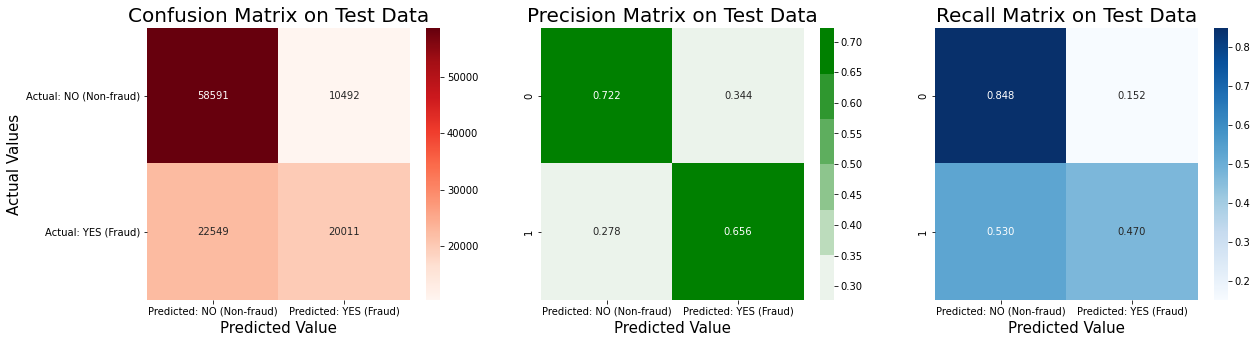

Percentage of misclassified points (Test Data):  29.595227645262128 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.15187528045973683
False Negative Rate (FNR) on Test Data:  0.5298167293233083
Balanced Accuracy Score (BACC) on Test Data:  0.6591539951084775
Matthew's Correlation Coefficient (MCC) on Test Data:  0.34693264372195476


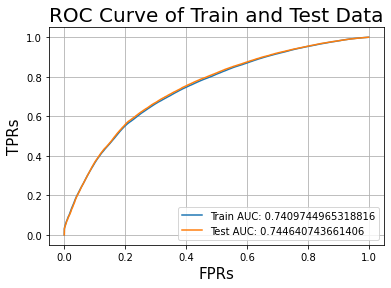

In [ ]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineLR1, xTestData=xTest, yTestData=yTest, xTrainData=xTrain, yTrainData=yTrain)

## <font color="blue">8.4. Logistic Regression - Hyperparameter Tuning on One Hot Encoded Data with balanced Class Weights</font>

In [ ]:
%%time
# Define an object of LogisticRegression Model
logReg2 = LogisticRegression(class_weight='balanced')

# Define different values for the Hyperparameters to do tuning
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2', 'elasticnet']
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using Logistic Regression
pipelineLR2 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('randomizedSearchCV', RandomizedSearchCV(logReg2, param_distributions=params, n_iter=10, cv=5, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data
pipelineLR2.fit(xTrain, yTrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 17.4 s, sys: 411 ms, total: 17.8 s
Wall time: 1min 34s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('OneHotEncoder',
                 OneHotEncoder(categoricalFeatures=['State', 'Country'])),
                ('randomizedSearchCV',
                 RandomizedSearchCV(cv=5,
                                    estimator=LogisticRegression(class_weight='balanced'),
                                    n_jobs=-1,
                                    param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                    

In [ ]:
print('Best Parameters found:', pipelineLR2.steps[2][1].best_params_)

Best Parameters found: {'penalty': 'l2', 'C': 1.0}


## <font color="blue">8.5. Logistic Regression - Train the Model now with best hyperparameters on One Hot Encoded Data with balanced Class Weights</font>

In [ ]:
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. Logistic Regression with best hyperparameters
pipelineLR2 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('logisticRegression', LogisticRegression(C=1, penalty='l2', class_weight='balanced'))
])

In [ ]:
%%time
# Fit the Pipeline on the Train Data
pipelineLR2.fit(xTrain, yTrain)

CPU times: user 14.1 s, sys: 184 ms, total: 14.3 s
Wall time: 14.3 s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('OneHotEncoder',
                 OneHotEncoder(categoricalFeatures=['State', 'Country'])),
                ('logisticRegression',
                 LogisticRegression(C=1, class_weight='balanced'))])

## <font color="blue">8.6. Logistic Regression - Evaluate the Model now on One Hot Encoded Test Data with balanced Class weights</font>

Log-loss of the Model on  Train  Dataset:  0.5974169163551892
Log-loss of the Model on  Test  Dataset:  0.5965035483210203
F1-Score of the Model on Test Data:  0.6239748584712745


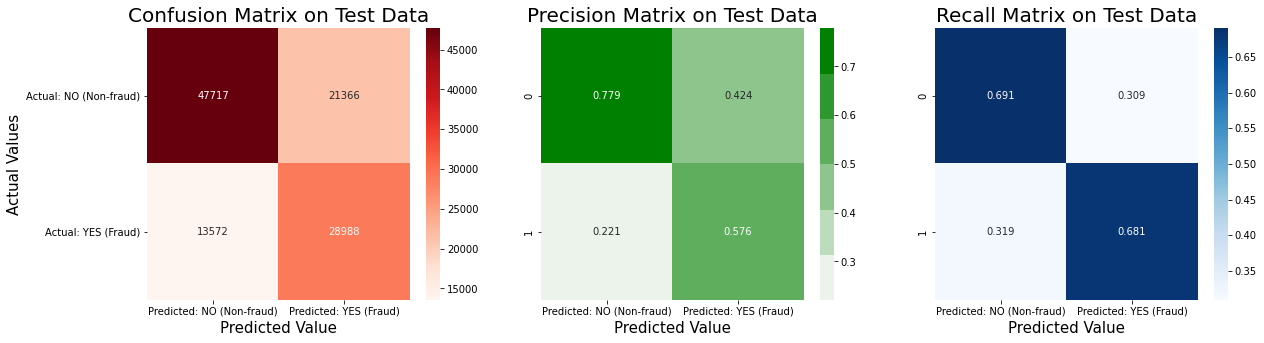

Percentage of misclassified points (Test Data):  31.29439373718012 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.3092801412793307
False Negative Rate (FNR) on Test Data:  0.318890977443609
Balanced Accuracy Score (BACC) on Test Data:  0.6859144406385301
Matthew's Correlation Coefficient (MCC) on Test Data:  0.3629286628287085


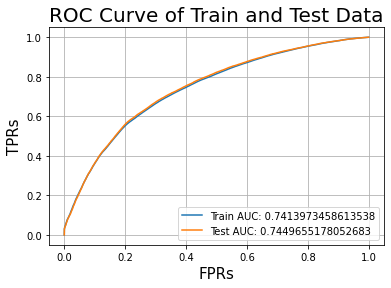

In [ ]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineLR2, xTestData=xTest, yTestData=yTest, xTrainData=xTrain, yTrainData=yTrain)

## <font color="blue">8.7. Logistic Regression - Hyperparameter Tuning on One Hot Encoded Data with Random Undersampling</font>

In [ ]:
%%time
# Define an object of LogisticRegression Model
logReg3 = LogisticRegression()

# Define different values for the Hyperparameters to do tuning
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2', 'elasticnet']
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using Logistic Regression
pipelineLR3 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('randomizedSearchCV', RandomizedSearchCV(logReg2, param_distributions=params, n_iter=10, cv=5, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data having random undersampling
pipelineLR3.fit(xTrainRndmUS, yTrainRndmUS)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 11.3 s, sys: 226 ms, total: 11.5 s
Wall time: 1min 8s


In [ ]:
print('Best Parameters found:', pipelineLR3.steps[2][1].best_params_)

Best Parameters found: {'penalty': 'l2', 'C': 100.0}


## <font color="blue">8.8. Logistic Regression - Train the Model now with best hyperparameters on One Hot Encoded Data with Random Undersampling</font>

In [ ]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. Logistic Regression with best hyperparameters
pipelineLR3 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('logisticRegression', LogisticRegression(C=100, penalty='l2'))
])

# Fit the Pipeline on the Train Data with random undersampling
pipelineLR3.fit(xTrainRndmUS, yTrainRndmUS)

CPU times: user 12.7 s, sys: 152 ms, total: 12.8 s
Wall time: 12.9 s


## <font color="blue">8.9. Logistic Regression - Evaluate the Model now on One Hot Encoded Test Data with Random Undersampling</font>

Log-loss of the Model on  Train  Dataset:  0.5987975749209773
Log-loss of the Model on  Test  Dataset:  0.5983131109324887
F1-Score of the Model on Test Data:  0.6243201948863697


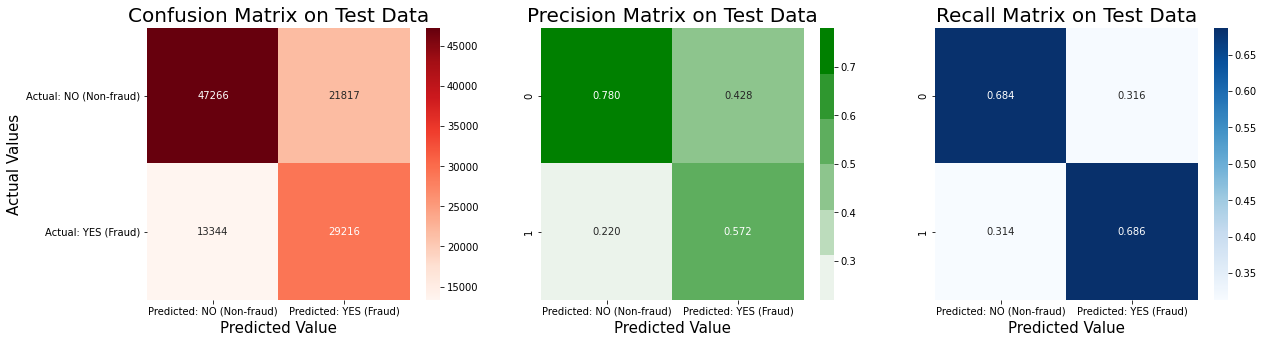

Percentage of misclassified points (Test Data):  31.494137563483605 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.31580852018586336
False Negative Rate (FNR) on Test Data:  0.31353383458646616
Balanced Accuracy Score (BACC) on Test Data:  0.6853288226138352
Matthew's Correlation Coefficient (MCC) on Test Data:  0.36137797073337047


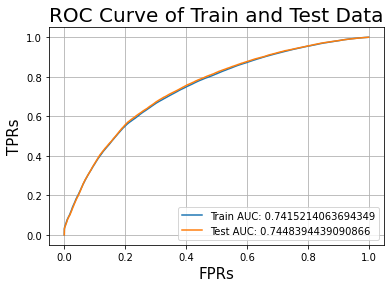

In [ ]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineLR3, xTestData=xTest, yTestData=yTest, xTrainData=xTrainRndmUS, yTrainData=yTrainRndmUS)

## <font color="blue">8.10. Logistic Regression - Hyperparameter Tuning on One Hot Encoded Data with SMOTE Oversampling</font>

In [ ]:
%%time
# Define an object of LogisticRegression Model
logReg4 = LogisticRegression()

# Define different values for the Hyperparameters to do tuning
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2', 'elasticnet']
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using Logistic Regression
pipelineLR4 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('randomizedSearchCV', RandomizedSearchCV(logReg2, param_distributions=params, n_iter=10, cv=5, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data having SMOTE Oversampling
pipelineLR4.fit(xTrainSMOTE, yTrainSMOTE)

print('Best Parameters found:', pipelineLR4.steps[2][1].best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters found: {'penalty': 'l2', 'C': 1.0}
CPU times: user 19.1 s, sys: 393 ms, total: 19.5 s
Wall time: 1min 55s


## <font color="blue">8.11. Logistic Regression - Train the Model now with best hyperparameters on One Hot Encoded Data with SMOTE Oversampling</font>

In [ ]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. Logistic Regression with best hyperparameters
pipelineLR4 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('logisticRegression', LogisticRegression(C=1, penalty='l2'))
])

# Fit the Pipeline on the Train Data with random undersampling
pipelineLR4.fit(xTrainSMOTE, yTrainSMOTE)

CPU times: user 18 s, sys: 228 ms, total: 18.2 s
Wall time: 18.3 s


## <font color="blue">8.12. Logistic Regression - Evaluate the Model now on One Hot Encoded Test Data with SMOTE Oversampling</font>

Log-loss of the Model on  Train  Dataset:  0.5408228818168359
Log-loss of the Model on  Test  Dataset:  0.6010448450217234
F1-Score of the Model on Test Data:  0.5726354409297723


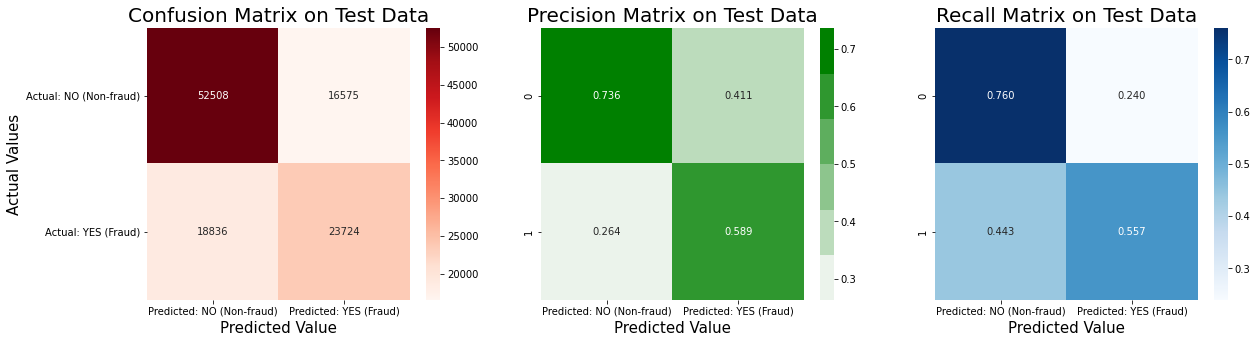

Percentage of misclassified points (Test Data):  31.718065619877645 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.23992878132101964
False Negative Rate (FNR) on Test Data:  0.4425751879699248
Balanced Accuracy Score (BACC) on Test Data:  0.6587480153545278
Matthew's Correlation Coefficient (MCC) on Test Data:  0.3210693450116765


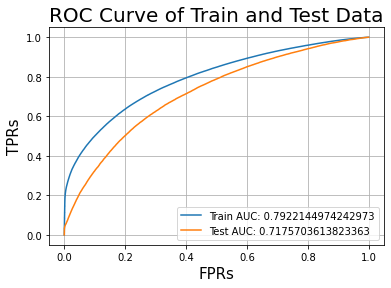

In [ ]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineLR4, xTestData=xTest, yTestData=yTest, xTrainData=xTrainSMOTE, yTrainData=yTrainSMOTE)

----

# <font color="blue">9. Decision Tree</font>

## <font color="blue">9.1. Decision Tree - Hyperparameter Tuning on Response Encoded Data without sampling</font>

In [ ]:
%%time
# Define an object of DecisionTreeClassifier Model
decisionTree1 = DecisionTreeClassifier()

# Define different values for the Hyperparameters to do tuning
params = {
    'max_depth': [1, 5, 10, 50, 100],
    'min_samples_split': [5, 10, 50, 100, 200, 500]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using Decision Tree
# Note: The order of Standardization and Response Encoding does not matter here because we are doing these encodings on different features.
pipelineDT1 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomizedSearchCV', RandomizedSearchCV(decisionTree1, param_distributions=params, n_iter=10, cv=5, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data
pipelineDT1.fit(xTrain, yTrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 12.8 s, sys: 615 ms, total: 13.4 s
Wall time: 3min 10s


In [ ]:
print('Best Parameters found:', pipelineDT1.steps[2][1].best_params_)

Best Parameters found: {'min_samples_split': 200, 'max_depth': 50}


## <font color="blue">9.2. Decision Tree - Train the Model now with best hyperparameters on Response Encoded Data without sampling</font>

In [ ]:
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding Encoding of 'State' and 'Country' features.
# 3. Decision Tree with best hyperparameters
pipelineDT1 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('decisionTree', DecisionTreeClassifier(min_samples_split=200, max_depth=50))
])

# Fit the Pipeline on the Train Data
pipelineDT1.fit(xTrain, yTrain)

Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('decisionTree',
                 DecisionTreeClassifier(max_depth=50, min_samples_split=200))])

## <font color="blue">9.3. Decision Tree - Evaluate the Model now on Response Encoded Test Data without sampling</font>

Log-loss of the Model on  Train  Dataset:  0.4336224638279036
Log-loss of the Model on  Test  Dataset:  0.6282826494511436
F1-Score of the Model on Test Data:  0.6855245418684776


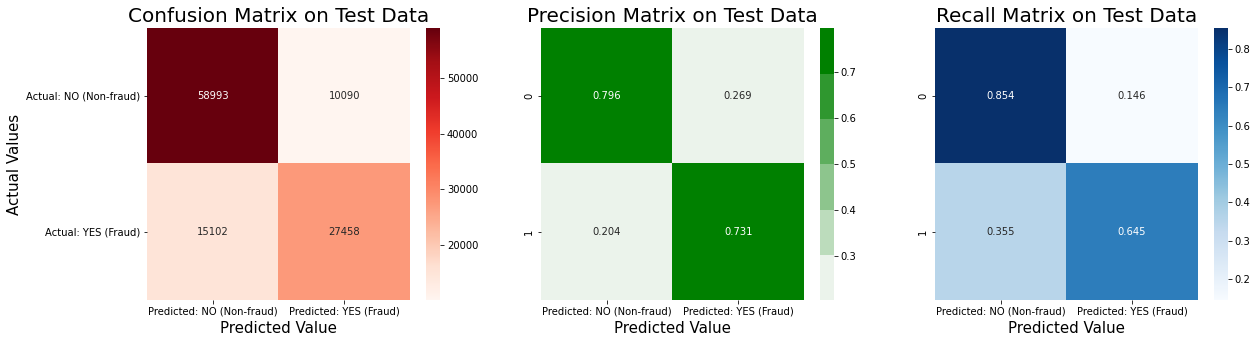

Percentage of misclassified points (Test Data):  22.564782386714796 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.14605619327475644
False Negative Rate (FNR) on Test Data:  0.35484022556390976
Balanced Accuracy Score (BACC) on Test Data:  0.7495517905806668
Matthew's Correlation Coefficient (MCC) on Test Data:  0.5130849008799907


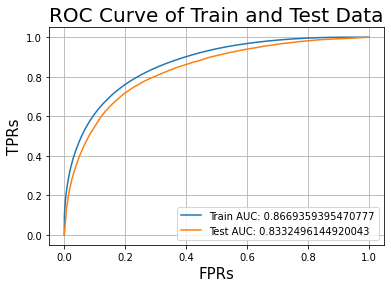

In [ ]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineDT1, xTestData=xTest, yTestData=yTest, xTrainData=xTrain, yTrainData=yTrain)

## <font color="blue">9.4. Decision Tree - Hyperparameter Tuning on Response Encoded Data with balanced Class Weights</font>

In [ ]:
%%time
# Define an object of DecisionTreeClassifier Model
decisionTree2 = DecisionTreeClassifier(class_weight='balanced')

# Define different values for the Hyperparameters to do tuning
params = {
    'max_depth': [1, 5, 10, 50, 100],
    'min_samples_split': [5, 10, 50, 100, 200, 500]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using Decision Tree
pipelineDT2 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomizedSearchCV', RandomizedSearchCV(decisionTree2, param_distributions=params, n_iter=10, cv=5, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data
pipelineDT2.fit(xTrain, yTrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 11 s, sys: 597 ms, total: 11.6 s
Wall time: 3min 22s


In [ ]:
print('Best Parameters found:', pipelineDT2.steps[2][1].best_params_)

Best Parameters found: {'min_samples_split': 200, 'max_depth': 50}


## <font color="blue">9.5. Decision Tree - Train the Model now with best hyperparameters on Response Encoded Data with balanced Class Weights</font>

In [ ]:
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding Encoding of 'State' and 'Country' features.
# 3. Decision Tree with best hyperparameters
pipelineDT2 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('decisionTree', DecisionTreeClassifier(min_samples_split=200, max_depth=50, class_weight='balanced'))
])

# Fit the Pipeline on the Train Data
pipelineDT2.fit(xTrain, yTrain)

Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('decisionTree',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=50,
                                        min_samples_split=200))])

## <font color="blue">9.6. Decision Tree - Evaluate the Model now on Response Encoded Test Data with balanced Class Weights</font>

Log-loss of the Model on  Train  Dataset:  0.45283764115467134
Log-loss of the Model on  Test  Dataset:  0.6331061406689386
F1-Score of the Model on Test Data:  0.7040438144046454


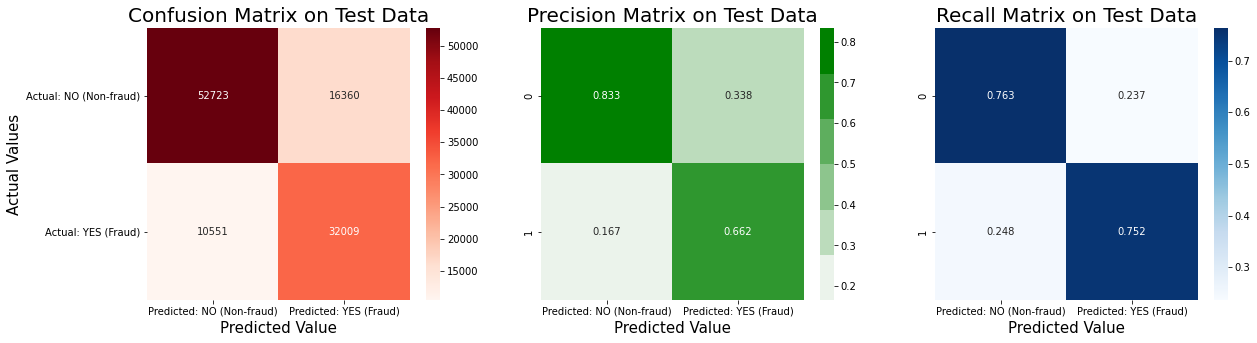

Percentage of misclassified points (Test Data):  24.104511702480227 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.23681658295094307
False Negative Rate (FNR) on Test Data:  0.24790883458646618
Balanced Accuracy Score (BACC) on Test Data:  0.7576372912312954
Matthew's Correlation Coefficient (MCC) on Test Data:  0.505043661314084


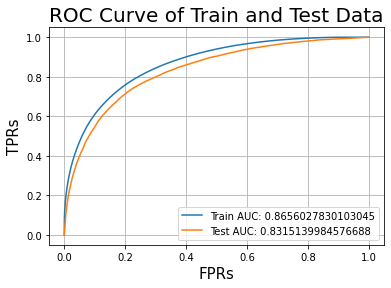

In [ ]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineDT2, xTestData=xTest, yTestData=yTest, xTrainData=xTrain, yTrainData=yTrain)

## <font color="blue">9.7. Decision Tree - Hyperparameter Tuning on Response Encoded Data with Random Undersampling</font>

In [ ]:
%%time
# Define an object of DecisionTreeClassifier Model
decisionTree3 = DecisionTreeClassifier()

# Define different values for the Hyperparameters to do tuning
params = {
    'max_depth': [1, 5, 10, 50, 100],
    'min_samples_split': [5, 10, 50, 100, 200, 500]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using Decision Tree
pipelineDT3 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomizedSearchCV', RandomizedSearchCV(decisionTree3, param_distributions=params, n_iter=10, cv=5, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data with Random Undersampling
pipelineDT3.fit(xTrainRndmUS, yTrainRndmUS)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 9.14 s, sys: 279 ms, total: 9.42 s
Wall time: 2min 15s


In [ ]:
print('Best Parameters found:', pipelineDT3.steps[2][1].best_params_)

Best Parameters found: {'min_samples_split': 200, 'max_depth': 50}


## <font color="blue">9.8. Decision Tree - Train the Model now with best hyperparameters on Response Encoded Data with Random Undersampling</font>

In [ ]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding Encoding of 'State' and 'Country' features.
# 3. Decision Tree with best hyperparameters
pipelineDT3 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('decisionTree', DecisionTreeClassifier(min_samples_split=200, max_depth=50))
])

# Fit the Pipeline on the Train Data with Random Undersampling
pipelineDT3.fit(xTrainRndmUS, yTrainRndmUS)

CPU times: user 7.3 s, sys: 132 ms, total: 7.43 s
Wall time: 7.5 s


## <font color="blue">9.9. Decision Tree - Evaluate the Model now on Response Encoded Test Data with Random Undersampling</font>

Log-loss of the Model on  Train  Dataset:  0.4597213523832759
Log-loss of the Model on  Test  Dataset:  0.6414190933440612
F1-Score of the Model on Test Data:  0.6991041121807355


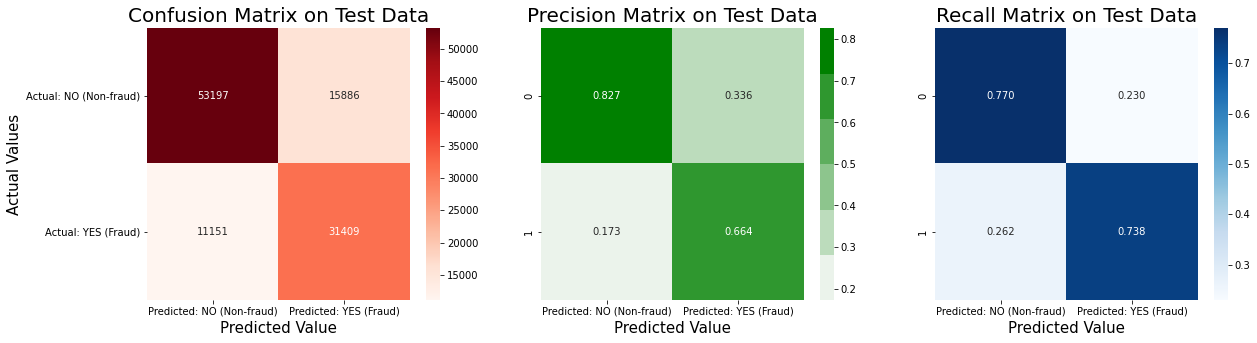

Percentage of misclassified points (Test Data):  24.217371442902824 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.22995527119551842
False Negative Rate (FNR) on Test Data:  0.2620065789473684
Balanced Accuracy Score (BACC) on Test Data:  0.7540190749285566
Matthew's Correlation Coefficient (MCC) on Test Data:  0.49935291384369784


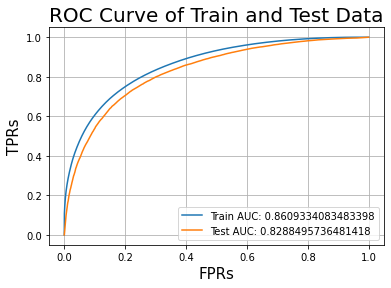

In [ ]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineDT3, xTestData=xTest, yTestData=yTest, xTrainData=xTrainRndmUS, yTrainData=yTrainRndmUS)

## <font color="blue">9.10. Decision Tree - Hyperparameter Tuning on Response Encoded Data with SMOTE Oversampling</font>

In [ ]:
%%time
# Define an object of DecisionTreeClassifier Model
decisionTree4 = DecisionTreeClassifier()

# Define different values for the Hyperparameters to do tuning
params = {
    'max_depth': [1, 5, 10, 50, 100],
    'min_samples_split': [5, 10, 50, 100, 200, 500]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using Decision Tree
pipelineDT4 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomizedSearchCV', RandomizedSearchCV(decisionTree4, param_distributions=params, n_iter=10, cv=5, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data with SMOTE Oversampling
pipelineDT4.fit(xTrainSMOTE, yTrainSMOTE)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 15 s, sys: 694 ms, total: 15.7 s
Wall time: 2min 57s


In [ ]:
print('Best Parameters found:', pipelineDT4.steps[2][1].best_params_)

Best Parameters found: {'min_samples_split': 200, 'max_depth': 50}


## <font color="blue">9.11. Decision Tree - Train the Model now with best hyperparameters on Response Encoded Data with SMOTE Oversampling</font>

In [ ]:
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding Encoding of 'State' and 'Country' features.
# 3. Decision Tree with best hyperparameters
pipelineDT4 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('decisionTree', DecisionTreeClassifier(min_samples_split=200, max_depth=50))
])

# Fit the Pipeline on the Train Data with Random Undersampling
pipelineDT4.fit(xTrainSMOTE, yTrainSMOTE)

Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('decisionTree',
                 DecisionTreeClassifier(max_depth=50, min_samples_split=200))])

## <font color="blue">9.12. Decision Tree - Evaluate the Model now on Response Encoded Test Data with SMOTE Oversampling</font>

Log-loss of the Model on  Train  Dataset:  0.4012060992137932
Log-loss of the Model on  Test  Dataset:  0.48393483172938895
F1-Score of the Model on Test Data:  0.706507017606942


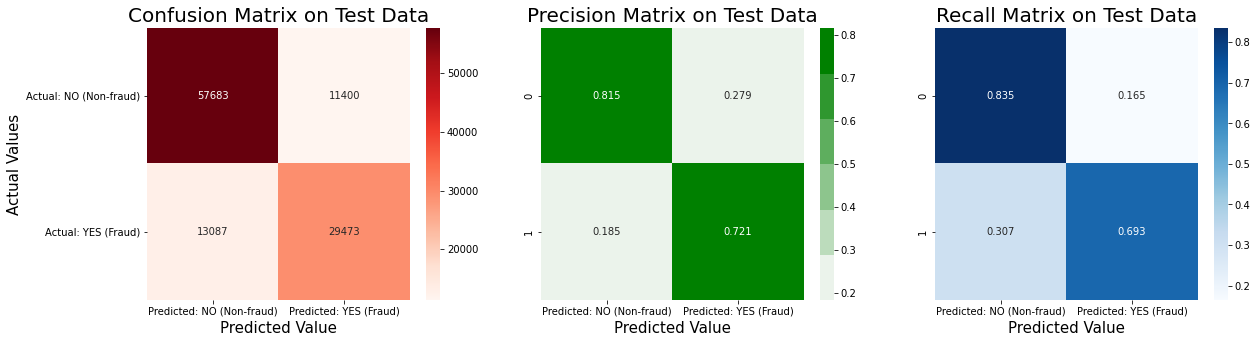

Percentage of misclassified points (Test Data):  21.933305267683597 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.1650188903203393
False Negative Rate (FNR) on Test Data:  0.3074953007518797
Balanced Accuracy Score (BACC) on Test Data:  0.7637429044638905
Matthew's Correlation Coefficient (MCC) on Test Data:  0.5318073421293075


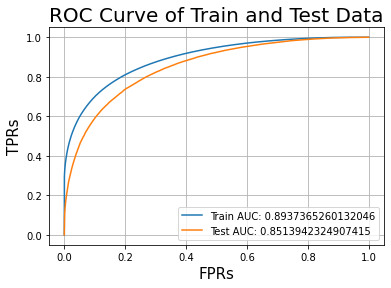

In [ ]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineDT4, xTestData=xTest, yTestData=yTest, xTrainData=xTrainSMOTE, yTrainData=yTrainSMOTE)

----

# <font color="blue">10. Random Forest</font>

## <font color="blue">10.1. Random Forest - Hyperparameter Tuning on Response Encoded Data without sampling</font>

In [47]:
%%time
# Define an object of RandomForestClassifier Model
rndmForest1 = RandomForestClassifier()

# Define different values for the Hyperparameters to do tuning
params = {
    'n_estimators': [50, 100, 200, 300, 500],
    'min_samples_split': [5, 10, 50, 100, 200, 500],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [1, 5, 10, 50, 100]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using RandomForest
# Note: The order of Standardization and Response Encoding does not matter here because we are doing these encodings on different features.
pipelineRF1 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomizedSearchCV', RandomizedSearchCV(rndmForest1, param_distributions=params, n_iter=5, cv=3, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data
pipelineRF1.fit(xTrain, yTrain)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 7min 2s, sys: 1.63 s, total: 7min 4s
Wall time: 22min 31s


In [48]:
print('Best Parameters found:', pipelineRF1.steps[2][1].best_params_)

Best Parameters found: {'n_estimators': 100, 'min_samples_split': 100, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 100}


## <font color="blue">10.2. Random Forest - Train the Model now with best hyperparameters on Response Encoded Data without sampling</font>

In [39]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding Encoding of 'State' and 'Country' features.
# 3. Decision Tree with best hyperparameters
pipelineRF1 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomForest', RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=100, min_samples_leaf=1, max_features=None))
])

# Fit the Pipeline on the Train Data
pipelineRF1.fit(xTrain, yTrain)

CPU times: user 6min 10s, sys: 869 ms, total: 6min 11s
Wall time: 6min 11s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('randomForest',
                 RandomForestClassifier(max_depth=100, max_features=None,
                                        min_samples_split=100))])

## <font color="blue">10.3. Random Forest - Evaluate the Model now on Response Encoded Test Data without sampling</font>

Log-loss of the Model on  Train  Dataset:  0.4051293002055571
Log-loss of the Model on  Test  Dataset:  0.46371504911089906
F1-Score of the Model on Test Data:  0.7000600630662195


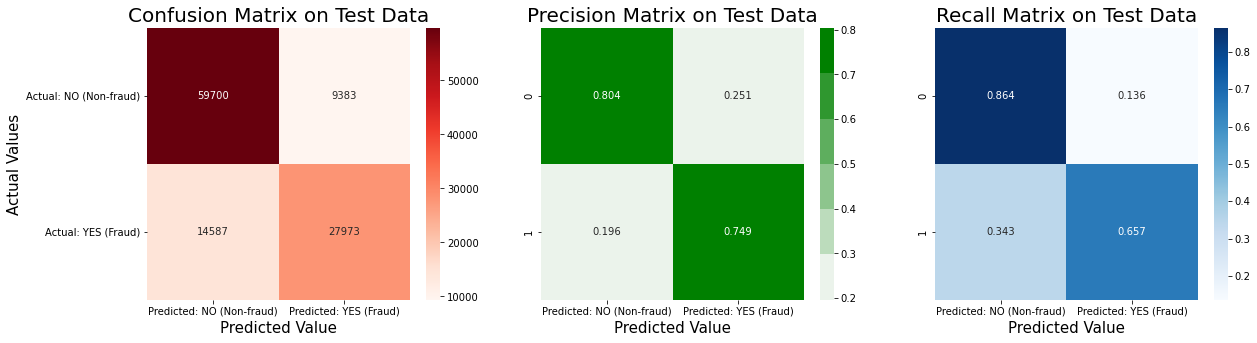

Percentage of misclassified points (Test Data):  21.47022204706072 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.13582212700664417
False Negative Rate (FNR) on Test Data:  0.34273966165413533
Balanced Accuracy Score (BACC) on Test Data:  0.7607191056696102
Matthew's Correlation Coefficient (MCC) on Test Data:  0.536726037371695


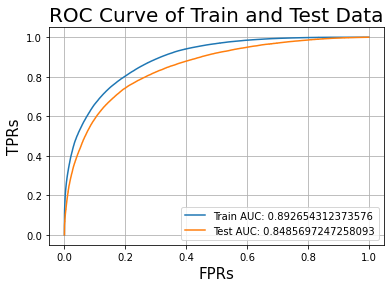

In [40]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineRF1, xTestData=xTest, yTestData=yTest, xTrainData=xTrain, yTrainData=yTrain)

## <font color="blue">10.4. Train a Calibrated Classifier on top of Random Forest</font>

* Let's try to use a Calibrated Model after Random Forest.

In [56]:
# Create a Calibrated Model object using the previous pipeline as the base estimator model.
calClassifier = CalibratedClassifierCV(base_estimator=pipelineRF1, method='sigmoid')

In [57]:
# Fit the Calibrated Classifier on the Train Data
calClassifier.fit(xTrain, yTrain)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('standardization',
                                                       Standardize(numericalFeatures=['Race',
                                                                                      'ClaimSettlementDelay',
                                                                                      'TreatmentDuration',
                                                                                      'Age',
                                                                                      'TotalClaimAmount',
                                                                                      'IPTotalAmount',
                                                                                      'OPTotalAmount',
                                                                                      'UniquePhysCount',
                                                                                      'PhysRoleCount'])),

Log-loss of the Model on  Train  Dataset:  0.4210876240988922
Log-loss of the Model on  Test  Dataset:  0.46688681702176194
F1-Score of the Model on Test Data:  0.6991133842710118


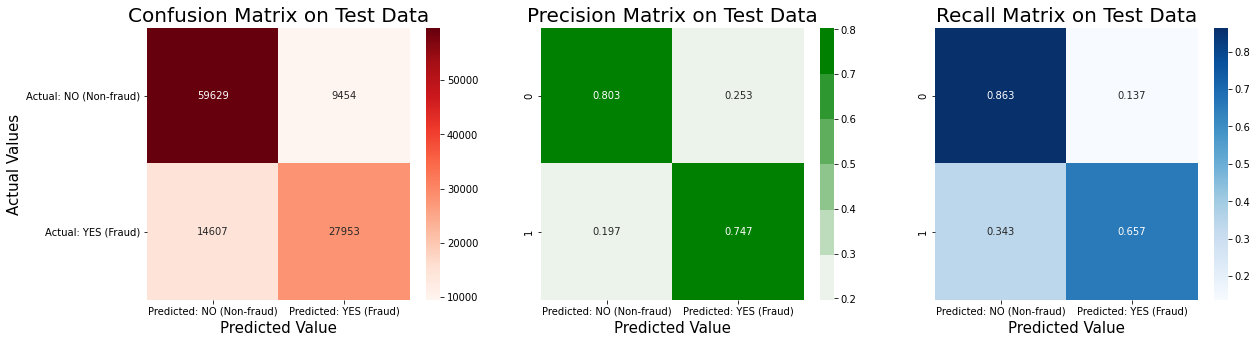

Percentage of misclassified points (Test Data):  21.551731859588152 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.13684987623583225
False Negative Rate (FNR) on Test Data:  0.3432095864661654
Balanced Accuracy Score (BACC) on Test Data:  0.7599702686490012
Matthew's Correlation Coefficient (MCC) on Test Data:  0.5350031774979324


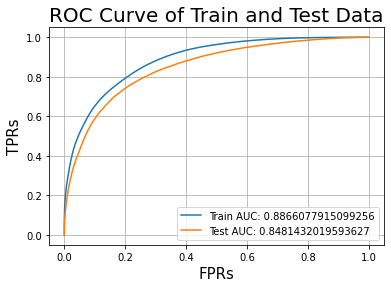

In [58]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=calClassifier, xTestData=xTest, yTestData=yTest, xTrainData=xTrain, yTrainData=yTrain)

## <font color="blue">10.5. Random Forest - Hyperparameter Tuning on Response Encoded Data with balanced Class Weights</font>

In [59]:
%%time
# Define an object of RandomForestClassifier Model
rndmForest2 = RandomForestClassifier(class_weight='balanced')

# Define different values for the Hyperparameters to do tuning
params = {
    'n_estimators': [50, 100, 200, 300],
    'min_samples_split': [5, 10, 50, 100, 200],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [1, 5, 10, 50, 100]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using RandomForest
# Note: The order of Standardization and Response Encoding does not matter here because we are doing these encodings on different features.
pipelineRF2 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomizedSearchCV', RandomizedSearchCV(rndmForest2, param_distributions=params, n_iter=5, cv=3, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data
pipelineRF2.fit(xTrain, yTrain)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 25min 38s, sys: 5.14 s, total: 25min 44s
Wall time: 1h 14min 20s


In [61]:
print('Best Parameters found:', pipelineRF2.steps[2][1].best_params_)

Best Parameters found: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 100}


## <font color="blue">10.6. Random Forest - Train the Model now with best hyperparameters on Response Encoded Data with balanced Class Weights</font>

In [62]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding Encoding of 'State' and 'Country' features.
# 3. Decision Tree with best hyperparameters
pipelineRF2 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomForest', RandomForestClassifier(class_weight='balanced', n_estimators=300, max_depth=100, min_samples_split=10, min_samples_leaf=4, max_features=None))
])

# Fit the Pipeline on the Train Data
pipelineRF2.fit(xTrain, yTrain)

CPU times: user 23min 5s, sys: 4.57 s, total: 23min 9s
Wall time: 23min 19s


## <font color="blue">10.7. Random Forest - Evaluate the Model now on Response Encoded Test Data with balanced Class Weights</font>

Log-loss of the Model on  Train  Dataset:  0.27579019912100344
Log-loss of the Model on  Test  Dataset:  0.4818633586272029
F1-Score of the Model on Test Data:  0.7074968412185877


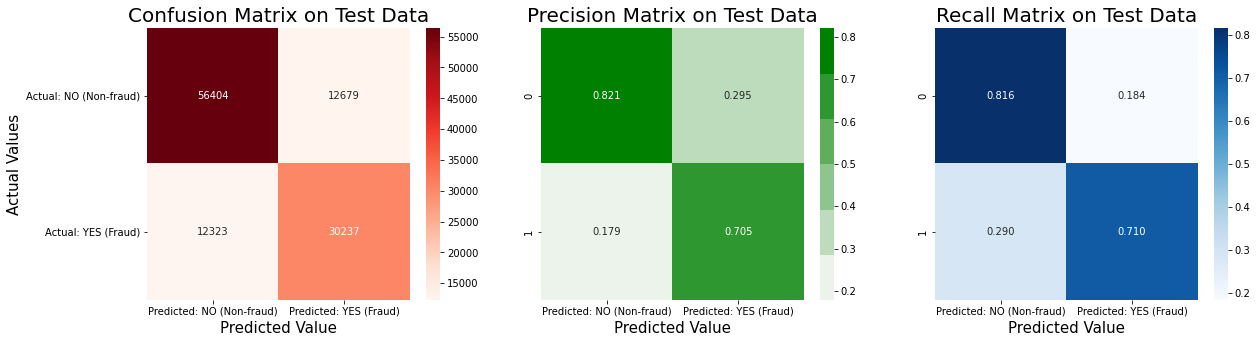

Percentage of misclassified points (Test Data):  22.394597063855322 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.18353285178698087
False Negative Rate (FNR) on Test Data:  0.2895441729323308
Balanced Accuracy Score (BACC) on Test Data:  0.7634614876403442
Matthew's Correlation Coefficient (MCC) on Test Data:  0.5260902192881475


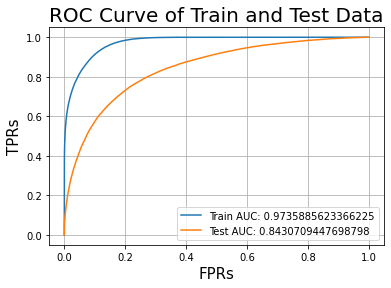

In [64]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineRF2, xTestData=xTest, yTestData=yTest, xTrainData=xTrain, yTrainData=yTrain)

## <font color="blue">10.8. Random Forest - Hyperparameter Tuning on Response Encoded Data with Random Undersampling</font>

In [41]:
%%time
# Define an object of RandomForestClassifier Model
rndmForest3 = RandomForestClassifier()

# Define different values for the Hyperparameters to do tuning
params = {
    'n_estimators': [50, 100, 200, 300],
    'min_samples_split': [5, 10, 50, 100, 200],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [1, 5, 10, 50, 100]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using RandomForest
# Note: The order of Standardization and Response Encoding does not matter here because we are doing these encodings on different features.
pipelineRF3 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomizedSearchCV', RandomizedSearchCV(rndmForest3, param_distributions=params, n_iter=5, cv=3, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data with Random Undersampling
pipelineRF3.fit(xTrainRndmUS, yTrainRndmUS)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 14min 31s, sys: 1.41 s, total: 14min 32s
Wall time: 24min 35s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('randomizedSearchCV',
                 RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                                    n_iter=5, n_jobs=-1,
                                    param_distributions={'max_depth': [1, 5, 10,
                                             

In [42]:
print('Best Parameters found:', pipelineRF3.steps[2][1].best_params_)

Best Parameters found: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 100}


## <font color="blue">10.9. Random Forest - Train the Model now with best hyperparameters on Response Encoded Data with Random Undersampling</font>

In [43]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding Encoding of 'State' and 'Country' features.
# 3. Decision Tree with best hyperparameters
pipelineRF3 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomForest', RandomForestClassifier(n_estimators=300, max_depth=100, min_samples_split=10, min_samples_leaf=4, max_features=None))
])

# Fit the Pipeline on the Train Data with Random Undersampling
pipelineRF3.fit(xTrainRndmUS, yTrainRndmUS)

CPU times: user 14min 32s, sys: 1.02 s, total: 14min 33s
Wall time: 14min 34s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('randomForest',
                 RandomForestClassifier(max_depth=100, max_features=None,
                                        min_samples_leaf=4,
                                        min_samples_split=10,
                                        n_estimators=300))])

## <font color="blue">10.10. Random Forest - Evaluate the Model now on Response Encoded Test Data with Random Undersampling</font>

Log-loss of the Model on  Train  Dataset:  0.284464327841572
Log-loss of the Model on  Test  Dataset:  0.4967193710762831
F1-Score of the Model on Test Data:  0.712699360718473


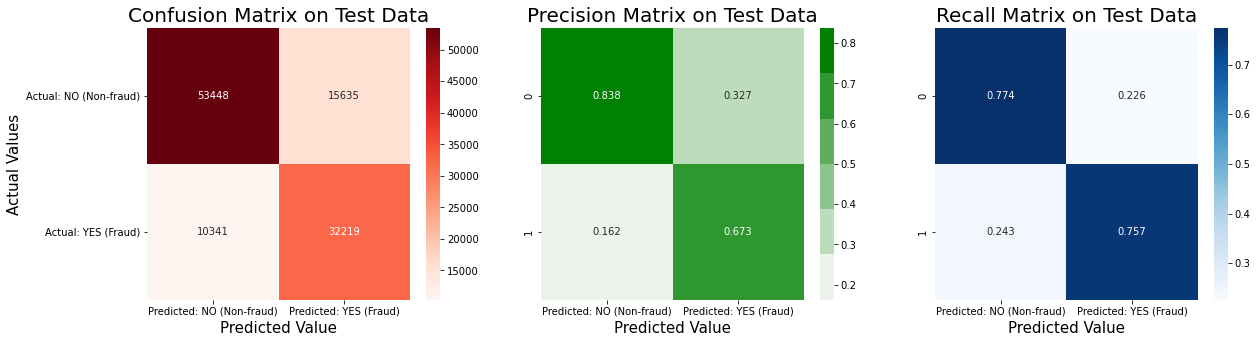

Percentage of misclassified points (Test Data):  23.26702077156651 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.22632196054021975
False Negative Rate (FNR) on Test Data:  0.24297462406015038
Balanced Accuracy Score (BACC) on Test Data:  0.765351707699815
Matthew's Correlation Coefficient (MCC) on Test Data:  0.520842322904782


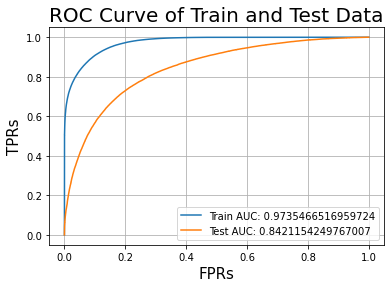

In [44]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineRF3, xTestData=xTest, yTestData=yTest, xTrainData=xTrainRndmUS, yTrainData=yTrainRndmUS)

## <font color="blue">10.11. Random Forest - Hyperparameter Tuning on Response Encoded Data with SMOTE Oversampling</font>

In [56]:
%%time
# Define an object of RandomForestClassifier Model
rndmForest4 = RandomForestClassifier()

# Define different values for the Hyperparameters to do tuning
params = {
    'n_estimators': [50, 100, 200, 300, 500, 1000],
    'min_samples_split': [5, 10, 50, 100, 200],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [1, 3, 5, 10, 50]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using RandomForest
# Note: The order of Standardization and Response Encoding does not matter here because we are doing these encodings on different features.
pipelineRF4 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomizedSearchCV', RandomizedSearchCV(rndmForest4, param_distributions=params, n_iter=5, cv=3, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data with SMOTE Oversampling
pipelineRF4.fit(xTrainSMOTE, yTrainSMOTE)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 39min 35s, sys: 2.35 s, total: 39min 37s
Wall time: 1h 8min 40s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('randomizedSearchCV',
                 RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                                    n_iter=5, n_jobs=-1,
                                    param_distributions={'max_depth': [1, 3, 5,
                                              

In [57]:
print('Best Parameters found:', pipelineRF4.steps[2][1].best_params_)

Best Parameters found: {'n_estimators': 500, 'min_samples_split': 50, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 50}


## <font color="blue">10.12. Random Forest - Train the Model now with best hyperparameters on Response Encoded Data with SMOTE Oversampling</font>

In [58]:
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using RandomForest
# Note: The order of Standardization and Response Encoding does not matter here because we are doing these encodings on different features.
pipelineRF4 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomForest', RandomForestClassifier(n_estimators=500, min_samples_split=50, min_samples_leaf=1, max_features=None, max_depth=50))
])

# Fit the Pipeline on the Train Data with SMOTE Oversampling
pipelineRF4.fit(xTrainSMOTE, yTrainSMOTE)

Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('randomForest',
                 RandomForestClassifier(max_depth=50, max_features=None,
                                        min_samples_split=50,
                                        n_estimators=500))])

## <font color="blue">10.13. Random Forest - Evaluate the Model now on Response Encoded Test Data with SMOTE Oversampling</font>

Log-loss of the Model on  Train  Dataset:  0.3299683248360122
Log-loss of the Model on  Test  Dataset:  0.3944738938948293
F1-Score of the Model on Test Data:  0.7621951957403037


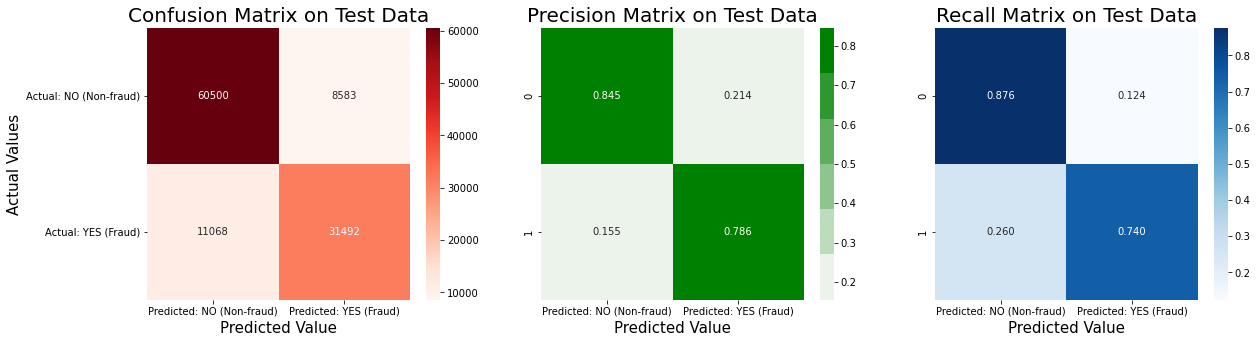

Percentage of misclassified points (Test Data):  17.601640944797257 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.12424185400170809
False Negative Rate (FNR) on Test Data:  0.2600563909774436
Balanced Accuracy Score (BACC) on Test Data:  0.8078508775104242
Matthew's Correlation Coefficient (MCC) on Test Data:  0.623391088606901


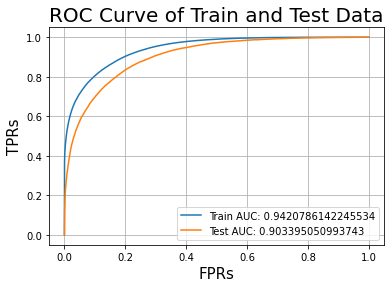

In [59]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineRF4, xTestData=xTest, yTestData=yTest, xTrainData=xTrainSMOTE, yTrainData=yTrainSMOTE)

----

# <font color="blue">10. XGBoost</font>

## <font color="blue">11.1. XGBoost - Hyperparameter Tuning on Response Encoded Data without sampling</font>

In [65]:
%%time
# Define an object of XGBoost Classifier Model
xgbClf1 = XGBClassifier()

# Define different values for the Hyperparameters to do tuning
params = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 200, 500, 1000, 2000],
    'max_depth': [3, 5, 10],
    'colsample_bytree': [0.1, 0.3, 0.5, 1],
    'subsample': [0.1, 0.3, 0.5, 1]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using XGBoost Classifier
# Note: The order of Standardization and Response Encoding does not matter here because we are doing these encodings on different features.
pipelineXGB1 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomizedSearchCV', RandomizedSearchCV(xgbClf1, param_distributions=params, n_iter=5, cv=3, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data
pipelineXGB1.fit(xTrain, yTrain)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 13min 57s, sys: 3.74 s, total: 14min 1s
Wall time: 1h 10min 23s


In [66]:
print('Best Parameters found:', pipelineXGB1.steps[2][1].best_params_)

Best Parameters found: {'subsample': 1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.3}


## <font color="blue">11.2. XGBoost - Train the Model now with best hyperparameters on Response Encoded Data without sampling</font>

In [67]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using XGBoost Classifier
pipelineXGB1 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('xgboost', XGBClassifier(subsample= 1, n_estimators=1000, max_depth=10, learning_rate=0.1, colsample_bytree=0.3))
])

# Fit the Pipeline on the Train Data
pipelineXGB1.fit(xTrain, yTrain)

CPU times: user 13min 44s, sys: 1.23 s, total: 13min 45s
Wall time: 13min 46s


## <font color="blue">11.3. XGBoost - Evaluate the Model now on Response Encoded Test Data without sampling</font>

Log-loss of the Model on  Train  Dataset:  0.35781286547248364
Log-loss of the Model on  Test  Dataset:  0.46636274258036986
F1-Score of the Model on Test Data:  0.6965269880150468


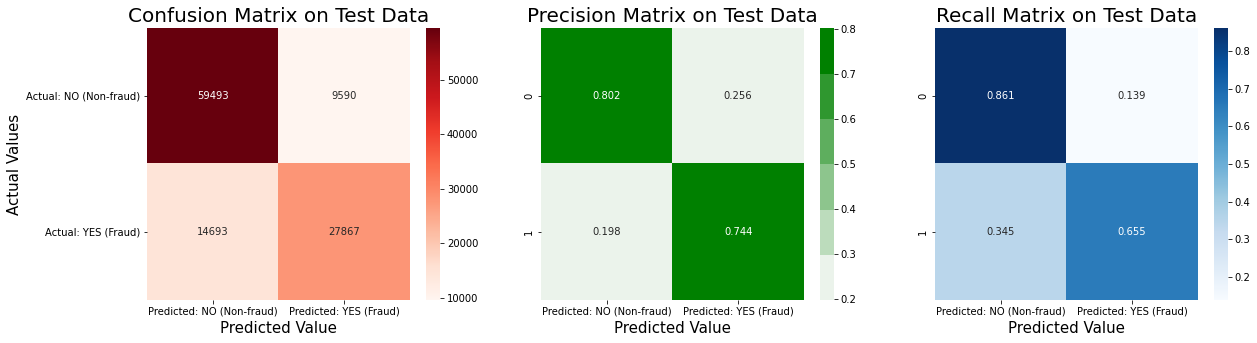

Percentage of misclassified points (Test Data):  21.75057997366606 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.13881852264667138
False Negative Rate (FNR) on Test Data:  0.34523026315789473
Balanced Accuracy Score (BACC) on Test Data:  0.7579756070977169
Matthew's Correlation Coefficient (MCC) on Test Data:  0.5307225854428906


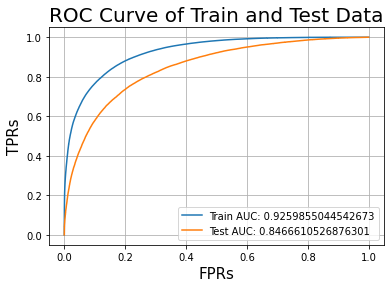

In [68]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineXGB1, xTestData=xTest, yTestData=yTest, xTrainData=xTrain, yTrainData=yTrain)

## <font color="blue">11.4. XGBoost - Hyperparameter Tuning on Response Encoded Data with balanced Class Weights</font>

* As we do not have class_weight parameter in the XGBoost Classifier, we will skip this case.

## <font color="blue">11.5. XGBoost - Hyperparameter Tuning on Response Encoded Data with Random Undersampling</font>

In [71]:
%%time
# Define an object of XGBoost Classifier Model
xgbClf3 = XGBClassifier()

# Define different values for the Hyperparameters to do tuning
params = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 200, 500, 1000, 2000],
    'max_depth': [3, 5, 10],
    'colsample_bytree': [0.1, 0.3, 0.5, 1],
    'subsample': [0.1, 0.3, 0.5, 1]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using XGBoost Classifier
# Note: The order of Standardization and Response Encoding does not matter here because we are doing these encodings on different features.
pipelineXGB3 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomizedSearchCV', RandomizedSearchCV(xgbClf3, param_distributions=params, n_iter=5, cv=3, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data
pipelineXGB3.fit(xTrainRndmUS, yTrainRndmUS)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 31min 36s, sys: 1.82 s, total: 31min 38s
Wall time: 1h 29min 42s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('randomizedSearchCV',
                 RandomizedSea...
                                                            reg_lambda=None,
                                                            scale_pos_weight=None,
                                                            subsamp

In [72]:
print('Best Parameters found:', pipelineXGB3.steps[2][1].best_params_)

Best Parameters found: {'subsample': 1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.3}


## <font color="blue">11.6. XGBoost - Train the Model now with best hyperparameters on Response Encoded Data with Random Undersampling</font>

In [73]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using XGBoost Classifier
pipelineXGB3 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('xgboost', XGBClassifier(subsample=1, n_estimators=1000, max_depth=10, learning_rate=0.1, colsample_bytree=0.3))
])

# Fit the Pipeline on the Train Data with Random Undersampling
pipelineXGB3.fit(xTrainRndmUS, yTrainRndmUS)

[08:39:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 31min 5s, sys: 884 ms, total: 31min 6s
Wall time: 1min 22s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('xgboost',
                 XGBClassifier(base_score...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
             

## <font color="blue">11.7. XGBoost - Evaluate the Model now on Response Encoded Test Data with Random Undersampling</font>

Log-loss of the Model on  Train  Dataset:  0.35703017229498873
Log-loss of the Model on  Test  Dataset:  0.4896131312281734
F1-Score of the Model on Test Data:  0.7153926654939771


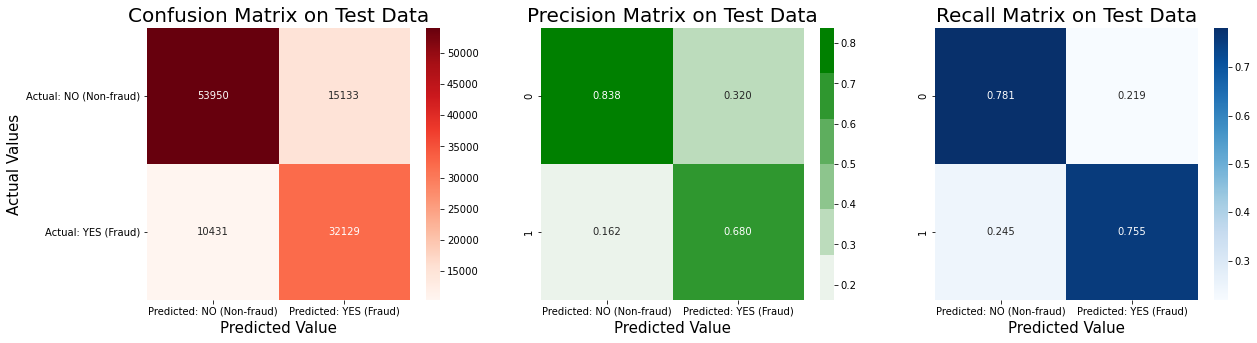

Percentage of misclassified points (Test Data):  22.89798733462913 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.21905533922962234
False Negative Rate (FNR) on Test Data:  0.2450892857142857
Balanced Accuracy Score (BACC) on Test Data:  0.767927687528046
Matthew's Correlation Coefficient (MCC) on Test Data:  0.5267433828626011


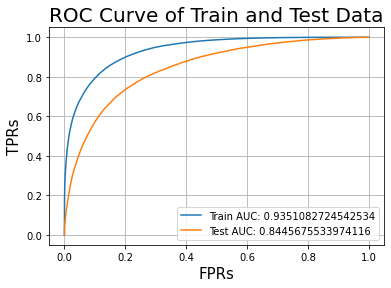

In [74]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineXGB3, xTestData=xTest, yTestData=yTest, xTrainData=xTrainRndmUS, yTrainData=yTrainRndmUS)

## <font color="blue">11.8. XGBoost - Hyperparameter Tuning on Response Encoded Data with SMOTE Oversampling</font>

In [78]:
%%time
# Define an object of XGBoost Classifier Model
xgbClf4 = XGBClassifier()

# Define different values for the Hyperparameters to do tuning
params = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 200, 500, 1000, 2000],
    'max_depth': [3, 5, 10],
    'colsample_bytree': [0.1, 0.3, 0.5, 1],
    'subsample': [0.1, 0.3, 0.5, 1]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using XGBoost Classifier
# Note: The order of Standardization and Response Encoding does not matter here because we are doing these encodings on different features.
pipelineXGB4 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('randomizedSearchCV', RandomizedSearchCV(xgbClf4, param_distributions=params, n_iter=5, cv=3, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data with SMOTE Oversampled data
pipelineXGB4.fit(xTrainSMOTE, yTrainSMOTE)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 51min 37s, sys: 3.71 s, total: 51min 40s
Wall time: 1h 32min 36s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('randomizedSearchCV',
                 RandomizedSea...
                                                            reg_lambda=None,
                                                            scale_pos_weight=None,
                                                            subsamp

In [79]:
print('Best Parameters found:', pipelineXGB4.steps[2][1].best_params_)

Best Parameters found: {'subsample': 1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.3}


## <font color="blue">11.9. XGBoost - Train the Model now with best hyperparameters on Response Encoded Data with SMOTE Oversampling</font>

In [80]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using XGBoost Classifier
pipelineXGB4 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('xgboost', XGBClassifier(subsample=1, n_estimators=1000, max_depth=10, learning_rate=0.1, colsample_bytree=0.3))
])

# Fit the Pipeline on the Train Data with SMOTE Oversampling
pipelineXGB4.fit(xTrainSMOTE, yTrainSMOTE)

[12:07:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 51min 57s, sys: 2.81 s, total: 51min 59s
Wall time: 2min 28s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('xgboost',
                 XGBClassifier(base_score...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
             

## <font color="blue">11.10. XGBoost - Evaluate the Model now on Response Encoded Test Data with SMOTE Oversampling</font>

Log-loss of the Model on  Train  Dataset:  0.3150195194700413
Log-loss of the Model on  Test  Dataset:  0.3935665350508559
F1-Score of the Model on Test Data:  0.7673355063393111


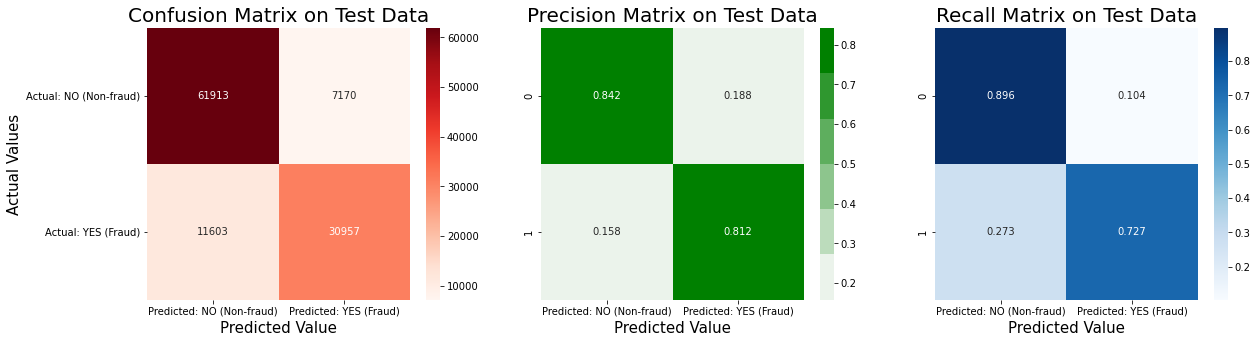

Percentage of misclassified points (Test Data):  16.815205610741383 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.10378819680673972
False Negative Rate (FNR) on Test Data:  0.27262687969924815
Balanced Accuracy Score (BACC) on Test Data:  0.811792461747006
Matthew's Correlation Coefficient (MCC) on Test Data:  0.638667415195444


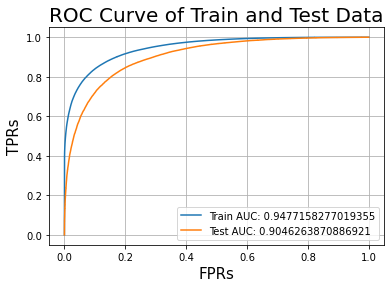

In [81]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineXGB4, xTestData=xTest, yTestData=yTest, xTrainData=xTrainSMOTE, yTrainData=yTrainSMOTE)

----

# <font color="blue">12. LightGBM Classifier</font>

## <font color="blue">12.1. LightGBM - Hyperparameter Tuning on Response Encoded Data without sampling</font>

In [39]:
%%time
# Define an object of LightGBM Model
lightGBM1 = LGBMClassifier()

# Define different values for the Hyperparameters to do tuning
# Reference: 'Hyperparameter Tuning in LightGBM' - https://www.kaggle.com/rtatman/lightgbm-hyperparameter-optimisation-lb-0-761
params = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 200, 500, 1000, 2000],
    'max_depth': [3, 5, 7, 10],
    'colsample_bytree': [0.1, 0.3, 0.5, 1],
    'subsample': [0.1, 0.3, 0.5, 1],
    'num_leaves': sp_randint(6, 50), 
    'min_child_samples': sp_randint(100, 500), 
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using LGBMClassifier
# Note: The order of Standardization and Response Encoding does not matter here because we are doing these encodings on different features.
pipelineLGBM1 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('lightGBM', RandomizedSearchCV(lightGBM1, param_distributions=params, n_iter=5, cv=3, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data
pipelineLGBM1.fit(xTrain, yTrain)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 3min 30s, sys: 1.42 s, total: 3min 32s
Wall time: 2min 7s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('lightGBM',
                 RandomizedSearchCV(cv=3...
                                                         'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff5c4b5d390>,
                                                         'min_child_weight': 

In [40]:
print('Best Parameters found:', pipelineLGBM1.steps[2][1].best_params_)

Best Parameters found: {'colsample_bytree': 0.3, 'learning_rate': 0.15, 'max_depth': 7, 'min_child_samples': 381, 'min_child_weight': 0.01, 'n_estimators': 1000, 'num_leaves': 43, 'reg_alpha': 1, 'reg_lambda': 10, 'subsample': 1}


## <font color="blue">12.2. LightGBM - Train the Model now with best hyperparameters on Response Encoded Data without sampling</font>

In [41]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. Train using LightGBM Classifier
pipelineLGBM1 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('xgboost', LGBMClassifier(colsample_bytree=0.3, learning_rate=0.15, max_depth=7, min_child_samples=381, 
                               min_child_weight=0.01, n_estimators=1000, num_leaves=43, reg_alpha=1, reg_lambda=10,
                               subsample=1))
])

# Fit the Pipeline on the Train Data
pipelineLGBM1.fit(xTrain, yTrain)

CPU times: user 3min 29s, sys: 1.01 s, total: 3min 30s
Wall time: 11.6 s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('xgboost',
                 LGBMClassifier(colsample_bytree=0.3, learning_rate=0.15,
                                max_depth=7, min_child_samples=381,
                                min_child_weight=0.01, n_estimators=1000,
                                num_leaves=43, reg_alpha

## <font color="blue">12.3. LightGBM - Evaluate the Model now on Response Encoded Test Data without sampling</font>

Log-loss of the Model on  Train  Dataset:  0.46374748610283156
Log-loss of the Model on  Test  Dataset:  0.4847911305025538
F1-Score of the Model on Test Data:  0.6767040508014543


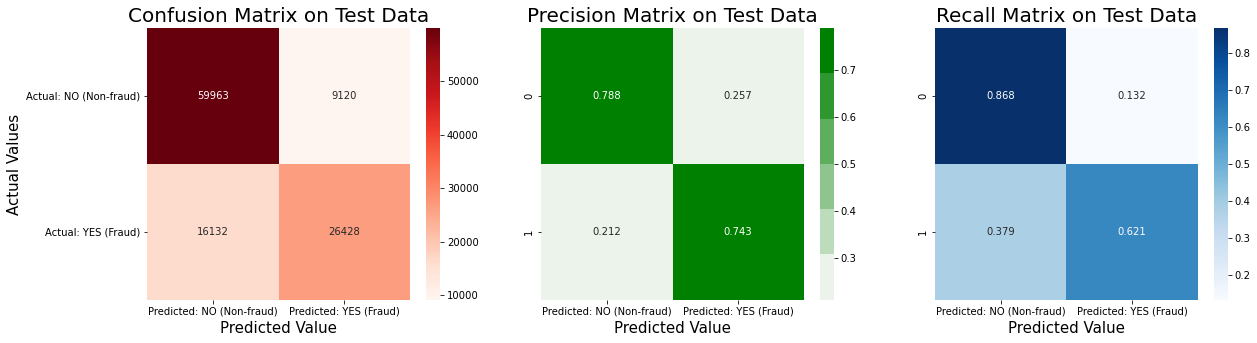

Percentage of misclassified points (Test Data):  22.618525120249366 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.13201511225627144
False Negative Rate (FNR) on Test Data:  0.3790413533834586
Balanced Accuracy Score (BACC) on Test Data:  0.7444717671801349
Matthew's Correlation Coefficient (MCC) on Test Data:  0.509752618365556


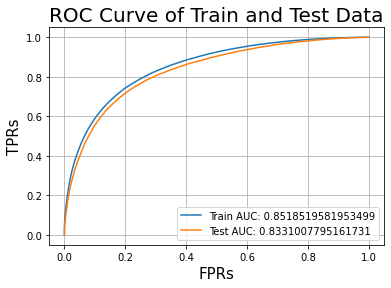

In [42]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineLGBM1, xTestData=xTest, yTestData=yTest, xTrainData=xTrain, yTrainData=yTrain)

## <font color="blue">12.4. LightGBM - Hyperparameter Tuning on Response Encoded Data with balanced Class Weight</font>

* As we do not have class_weight parameter in the LightGBM Classifier, we will skip this case.

## <font color="blue">12.5. LightGBM - Hyperparameter Tuning on Response Encoded Data with Random Undersampling</font>

In [43]:
%%time
# Define an object of LightGBM Model
lightGBM2 = LGBMClassifier()

# Define different values for the Hyperparameters to do tuning
# Reference: 'Hyperparameter Tuning in LightGBM' - https://www.kaggle.com/rtatman/lightgbm-hyperparameter-optimisation-lb-0-761
params = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 200, 500, 1000, 2000],
    'max_depth': [3, 5, 7, 10],
    'colsample_bytree': [0.1, 0.3, 0.5, 1],
    'subsample': [0.1, 0.3, 0.5, 1],
    'num_leaves': sp_randint(6, 50), 
    'min_child_samples': sp_randint(100, 500), 
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using LGBMClassifier
# Note: The order of Standardization and Response Encoding does not matter here because we are doing these encodings on different features.
pipelineLGBM2 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('lightGBM', RandomizedSearchCV(lightGBM2, param_distributions=params, n_iter=5, cv=3, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data with Random Undersampling
pipelineLGBM2.fit(xTrainRndmUS, yTrainRndmUS)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 2min 57s, sys: 1.33 s, total: 2min 58s
Wall time: 1min 34s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('lightGBM',
                 RandomizedSearchCV(cv=3...
                                                         'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff5f92b6a10>,
                                                         'min_child_weight': 

In [44]:
print('Best Parameters found:', pipelineLGBM2.steps[2][1].best_params_)

Best Parameters found: {'colsample_bytree': 0.3, 'learning_rate': 0.15, 'max_depth': 7, 'min_child_samples': 381, 'min_child_weight': 0.01, 'n_estimators': 1000, 'num_leaves': 43, 'reg_alpha': 1, 'reg_lambda': 10, 'subsample': 1}


## <font color="blue">12.6. LightGBM - Train the Model now with best hyperparameters on Response Encoded Data with Random Undersampling</font>

In [46]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. Train using LightGBM Classifier
pipelineLGBM2 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('xgboost', LGBMClassifier(colsample_bytree=0.3, learning_rate=0.15, max_depth=7, min_child_samples=381, 
                               min_child_weight=0.01, n_estimators=1000, num_leaves=43, reg_alpha=1, reg_lambda=10,
                               subsample=1))
])

# Fit the Pipeline on the Train Data with Random Undersampling
pipelineLGBM2.fit(xTrainRndmUS, yTrainRndmUS)

CPU times: user 2min 54s, sys: 716 ms, total: 2min 55s
Wall time: 9.52 s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('xgboost',
                 LGBMClassifier(colsample_bytree=0.3, learning_rate=0.15,
                                max_depth=7, min_child_samples=381,
                                min_child_weight=0.01, n_estimators=1000,
                                num_leaves=43, reg_alpha

## <font color="blue">12.7. LightGBM - Evaluate the Model now on Response Encoded Test Data with Random Undersampling</font>

Log-loss of the Model on  Train  Dataset:  0.4825936485756423
Log-loss of the Model on  Test  Dataset:  0.5086560216299112
F1-Score of the Model on Test Data:  0.7021471911873364


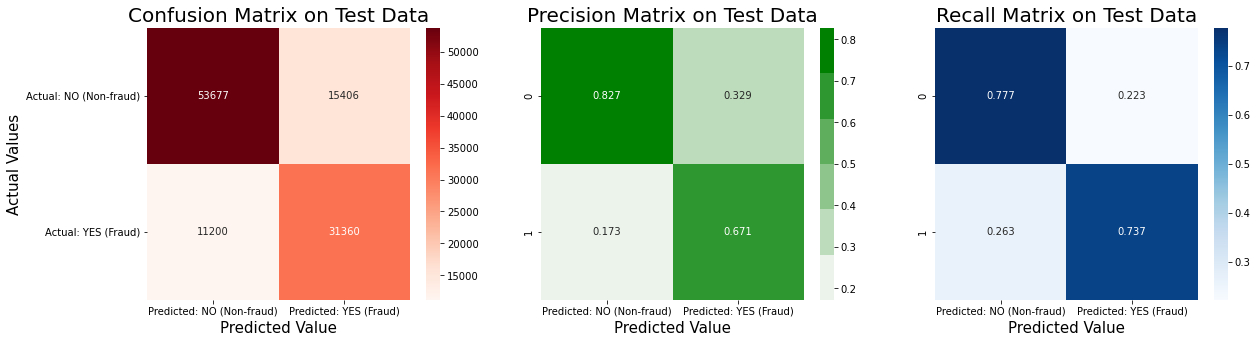

Percentage of misclassified points (Test Data):  23.831319473679496 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.22300710739255677
False Negative Rate (FNR) on Test Data:  0.2631578947368421
Balanced Accuracy Score (BACC) on Test Data:  0.7569174989353005
Matthew's Correlation Coefficient (MCC) on Test Data:  0.5058241880136458


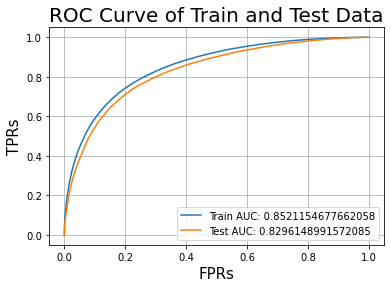

In [47]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineLGBM2, xTestData=xTest, yTestData=yTest, xTrainData=xTrainRndmUS, yTrainData=yTrainRndmUS)

## <font color="blue">12.8. LightGBM - Hyperparameter Tuning on Response Encoded Data with SMOTE Oversampling</font>

In [48]:
%%time
# Define an object of LightGBM Model
lightGBM3 = LGBMClassifier()

# Define different values for the Hyperparameters to do tuning
# Reference: 'Hyperparameter Tuning in LightGBM' - https://www.kaggle.com/rtatman/lightgbm-hyperparameter-optimisation-lb-0-761
params = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 200, 500, 1000, 2000],
    'max_depth': [3, 5, 7, 10],
    'colsample_bytree': [0.1, 0.3, 0.5, 1],
    'subsample': [0.1, 0.3, 0.5, 1],
    'num_leaves': sp_randint(6, 50), 
    'min_child_samples': sp_randint(100, 500), 
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using LGBMClassifier
# Note: The order of Standardization and Response Encoding does not matter here because we are doing these encodings on different features.
pipelineLGBM3 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('lightGBM', RandomizedSearchCV(lightGBM3, param_distributions=params, n_iter=5, cv=3, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data with SMOTE Oversampling
pipelineLGBM3.fit(xTrainSMOTE, yTrainSMOTE)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 4min 20s, sys: 1.29 s, total: 4min 21s
Wall time: 2min 40s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('lightGBM',
                 RandomizedSearchCV(cv=3...
                                                         'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff5c4c01490>,
                                                         'min_child_weight': 

In [49]:
print('Best Parameters found:', pipelineLGBM3.steps[2][1].best_params_)

Best Parameters found: {'colsample_bytree': 0.3, 'learning_rate': 0.15, 'max_depth': 7, 'min_child_samples': 381, 'min_child_weight': 0.01, 'n_estimators': 1000, 'num_leaves': 43, 'reg_alpha': 1, 'reg_lambda': 10, 'subsample': 1}


## <font color="blue">12.9. LightGBM - Train the Model now with best hyperparameters on Response Encoded Data with SMOTE Oversampling</font>

In [50]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. Response Encoding of 'State' and 'Country' features.
# 3. Train using LightGBM Classifier
pipelineLGBM3 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', ResponseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('xgboost', LGBMClassifier(colsample_bytree=0.3, learning_rate=0.15, max_depth=7, min_child_samples=381, 
                               min_child_weight=0.01, n_estimators=1000, num_leaves=43, reg_alpha=1, reg_lambda=10,
                               subsample=1))
])

# Fit the Pipeline on the Train Data with SMOTE Oversampling
pipelineLGBM3.fit(xTrainSMOTE, yTrainSMOTE)

CPU times: user 4min 20s, sys: 1.14 s, total: 4min 22s
Wall time: 16 s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('xgboost',
                 LGBMClassifier(colsample_bytree=0.3, learning_rate=0.15,
                                max_depth=7, min_child_samples=381,
                                min_child_weight=0.01, n_estimators=1000,
                                num_leaves=43, reg_alpha

## <font color="blue">12.10. LightGBM - Evaluate the Model now on Response Encoded Test Data with SMOTE Oversampling</font>

Log-loss of the Model on  Train  Dataset:  0.41068098976986656
Log-loss of the Model on  Test  Dataset:  0.4848286591011508
F1-Score of the Model on Test Data:  0.6841537457975814


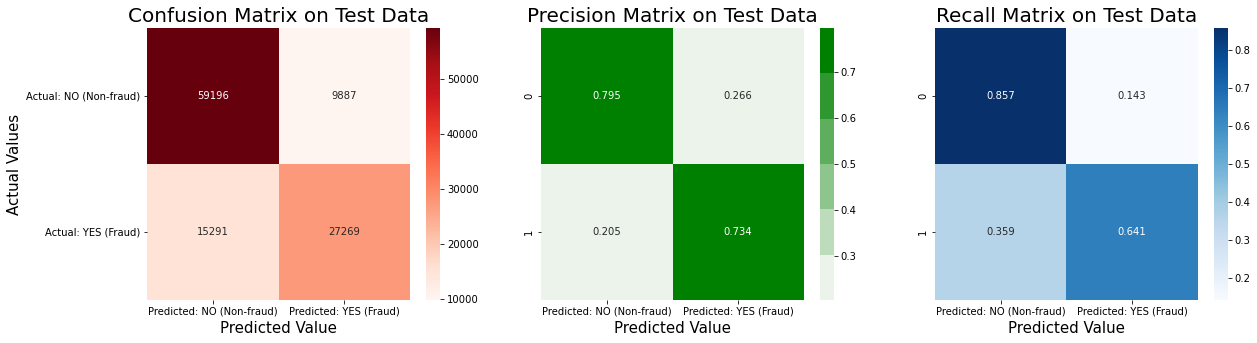

Percentage of misclassified points (Test Data):  22.55224241555673 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.1431176989997539
False Negative Rate (FNR) on Test Data:  0.35928101503759396
Balanced Accuracy Score (BACC) on Test Data:  0.7488006429813261
Matthew's Correlation Coefficient (MCC) on Test Data:  0.5128769479586289


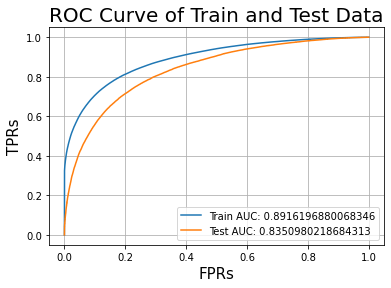

In [51]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineLGBM3, xTestData=xTest, yTestData=yTest, xTrainData=xTrainSMOTE, yTrainData=yTrainSMOTE)

----

# <font color="blue">13. Comparisons of the Performances of all the Models</font>

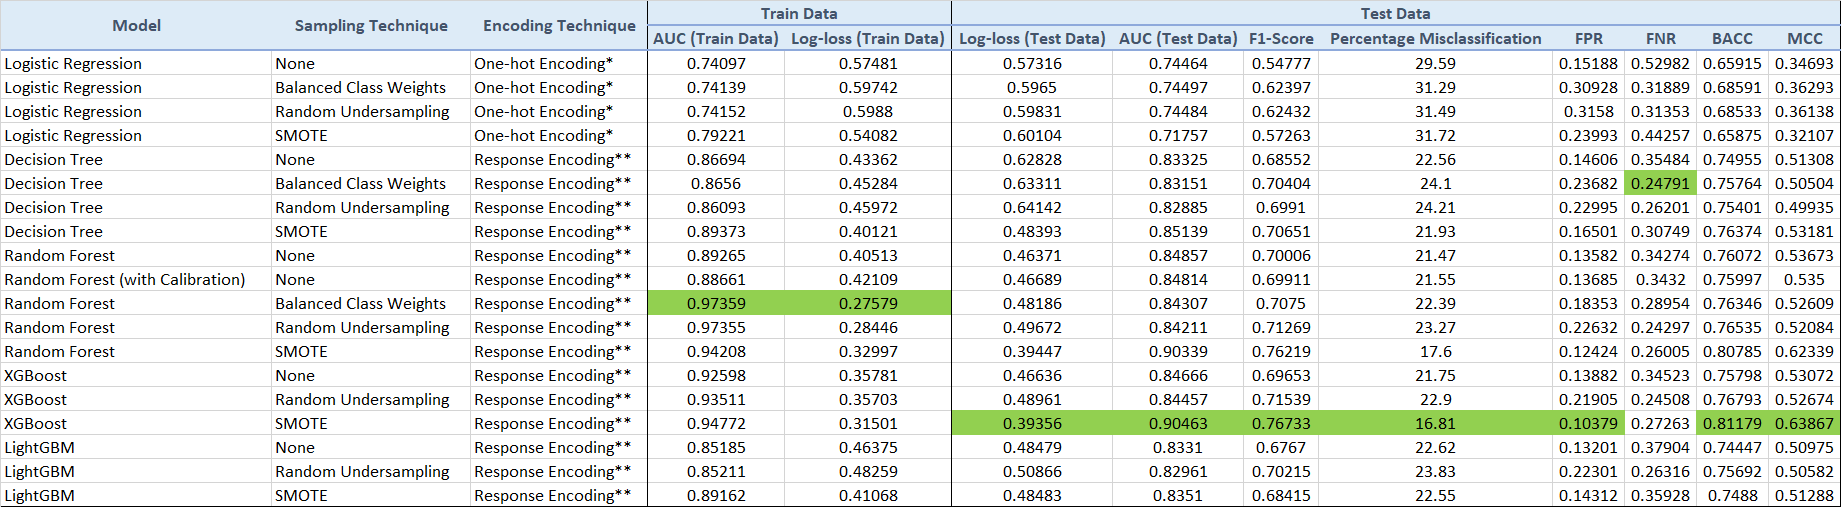

One-Hot Encoding\*: One-hot Encoding of 'State' and 'Country' features.<br>
Response Encoding\*\*: Response Encoding of 'State' and 'Country' features.

* We can observe that,<br>
&emsp; 1. Decision Tree with balanced class weights received the least 'FNR' score of 0.24791.<br>
&emsp; 2. Random Forest with balanced class weights received the minimum 'Train AUC' and minimum 'Train Log-loss'.<br>
&emsp; 3. XGBoost with SMOTE Oversampling received the least 'Test Log-loss', 'percentage misclassification', 'FPR' and the maximum 'Test AUC', 'F1-Score', 'BACC' and 'MCC' score.<br>


#### <font color="blue">Conclusion</font>
* As the XGBoost Model with SMOTE oversampling gives the best scores for most of the performance metrics, we will choose **XGBoost with SMOTE Oversampling** as the final model.

----

# <font color="blue">14. Save the best Model (XGBoost with SMOTE Oversampling)</font>

* As we have used sklearn pipeline for build and training the Model and it uses custom implementation of response encoding and standarization, we need to create them as separate package/module and use them when we need to load the saved model.
* Created a custom package called 'custom_package' with different modules, each for doing response encoding, one-hot encoding and standardization.

## <font color="blue">14.1. Import the custom modules for Response Encoding and Standardization</font>

In [24]:
# Import the Response Encoder and Standarize Module from the custom package.
from custom_package.response_encoder import ResponseEncoder as responseEncoder
from custom_package.standardize import Standardize as standardize

## <font color="blue">14.2. Train the XGBoost Model</font>

* Train the XGBoost Model once again using the custom modules for doing Response Encoding of 'State' and 'Country' features, and Standarization of the numerical features.
* Use of Custom modules is necessary because we are using a pipeline model and saving/loading of the model requires the same used packages/modules to be present.

In [27]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features using custom 'Standardize' module.
# 2. Response Encoding of 'State' and 'Country' features using custom 'ResponseEncoder' module.
# 3. RandomizedSearchCV using XGBoost Classifier
pipelineXGB = sklearnPipeline(steps=[
    ('standardization', standardize(numericalFeatures=featuresToStd)),
    ('responseEncoding', responseEncoder(categoricalFeatures=['State', 'Country'], className='PotentialFraud')),
    ('xgboost', XGBClassifier(subsample=1, n_estimators=1000, max_depth=10, learning_rate=0.1, colsample_bytree=0.3))
])

# Fit the Pipeline on the Train Data with SMOTE Oversampling
pipelineXGB.fit(xTrainSMOTE, yTrainSMOTE)

CPU times: user 54min 17s, sys: 3.21 s, total: 54min 20s
Wall time: 2min 37s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('responseEncoding',
                 ResponseEncoder(categoricalFeatures=['State', 'Country'],
                                 className='PotentialFraud')),
                ('xgboost',
                 XGBClassifier(base_score...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
             

## <font color="blue">14.3. Save the Model</font>

In [29]:
# Save the model
with open('Model/BestModel.pkl', 'wb') as f:
    pickle.dump(pipelineXGB, f)

* Reference: 'AttributeError: Can't get attribute 'new_block' on <module 'pandas.core.internals.blocks' - https://stackoverflow.com/a/69698232/16007029'
* Note: Ensure that the below packages are present in the environment, where the model is to be loaded:<br>
&emsp; i. pandas==1.3.5<br>
&emsp; ii. scikit-learn==1.0.2<br>
&emsp; iii. xgboost==1.5.2<br>
* Command to install specific versions for these packages:

> pip install pandas==1.3.5

> pip install -U scikit-learn

> pip install xgboost==1.5.2

In [38]:
print('Pandas Version: ', pd.__version__)

Pandas Version:  1.3.5


In [39]:
print('Sklearn Version:', sklearn.__version__)

Sklearn Version: 1.0.2


In [41]:
print('XGBoost Version: ', xgb.__version__)

XGBoost Version:  1.5.2


----